In [258]:
#script written by Francesco on 02/04/2017 to analyze transport measurements
#modified for SAG loop measurements
import numpy as np
import scipy.optimize as op
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import cmath
import scipy as sci
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy import signal
from scipy.fftpack import fft, ifft
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import scipy.special as sp
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.collections as collections
import scipy.optimize as op
import importlib
import analysis as a

%matplotlib inline


mpl.rcParams['figure.dpi'] = 300 #dpi
title_font=14
axes_font=14
tick_font=14
marker_size=6
text_font=16
caption_font=18
legend_font = 10

sub_hspace=8    
sub_wspace=1

limit_fit = 6000
phi_0 = 4.135667513e-15


#contact resistance
R_c = 8000

In [274]:
importlib.reload(a)

<module 'analysis' from 'D:\\pycharmprojects\\insects\\analysis.py'>

# Function definitions 

In [122]:
A2 = 0
B2 = 0
offset = 0

def single_trace(inputFiles, label_x, conversions_x, label_y, conversions_y, labels, column, plot_name):
    
    fig = plt.figure(figsize=(8, 5))
    ax1 = plt.subplot2grid((1,1), (0,0), colspan=1)
    ax1.set_xlabel( str(label_x), fontsize=axes_font)
    ax1.set_ylabel( str(label_y), fontsize=axes_font)
    ax1.get_xaxis().get_major_formatter().set_useOffset(False)
    
    for inputFile in inputFiles:        
        x = []
        y = []
             
        data = np.loadtxt(inputFile)
        x = conversions_x[inputFiles.index(inputFile)]*np.array(data[1:,0])
        y = conversions_y[inputFiles.index(inputFile)]*np.array(data[1:,column])  
        ax1.plot(x, y,  linewidth=1, label = str(labels[inputFiles.index(inputFile)]))       
        ax1.legend(loc=0, fontsize = legend_font)
        
        
    fig.subplots_adjust(hspace=sub_hspace)    
    fig.subplots_adjust(wspace=sub_wspace)    
    fig.tight_layout() 
    fig.savefig(str(plot_name)+'.eps',format='eps',transparent = False)
    fig.savefig(str(plot_name)+'.png',format='png',transparent = False)
    
    return


def gate_dependance(inputFiles, gates, conversions, labels, plot_name):
    
    fig = plt.figure(figsize=(8,3))
    ax1 = plt.subplot2grid((1,2), (0,0), colspan=1)
    ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)
        
    
    ax1.set_xlabel( 'V', fontsize=axes_font)
    ax1.set_ylabel('I ($\mu $ A)', fontsize=axes_font)
    #ax1.tick_params(axis='both', which='major', labelsize=tick_font)
    ax1.get_xaxis().get_major_formatter().set_useOffset(False)
    ax1.set_ylim(0, 0.130)


    ax2.set_xlabel( 'V', fontsize=axes_font)
    ax2.set_ylabel('G ($ 2e^2/h$)', fontsize=axes_font)
    #ax2.tick_params(axis='both', which='major', labelsize=tick_font)
    ax2.get_xaxis().get_major_formatter().set_useOffset(False)
    
 
    
    for inputFile in inputFiles:        
        Vg = []
        I = []
        G = []        
        data = np.loadtxt(inputFile)
        Vg = conversions[inputFiles.index(inputFile)]*np.array(data[1:,0]) 
        I = np.array(data[1:,4])
        G = 12906.0*np.array(data[1:,3])        

        #ax1.plot(Vg, I,  linewidth=2, label = gates[inputFiles.index(inputFile)]+' Vbias:'+ Vs[inputFiles.index(inputFile)])
        #ax2.plot(Vg, G,  linewidth=2, label = gates[inputFiles.index(inputFile)]+' Vbias:'+ Vs[inputFiles.index(inputFile)])
        ax1.plot(Vg, I,  linewidth=2, label = str(labels[inputFiles.index(inputFile)]))
        ax2.plot(Vg, G,  linewidth=2, label = str(labels[inputFiles.index(inputFile)]))        
        ax1.legend(loc=0, fontsize = legend_font)
        ax2.legend(loc=0, fontsize = legend_font)
        
    fig.subplots_adjust(hspace=sub_hspace)    
    fig.subplots_adjust(wspace=sub_wspace)    
    fig.tight_layout() 
    fig.savefig('gates'+str(plot_name)+'.eps',format='eps',transparent = False)
    fig.savefig('gates'+str(plot_name)+'.png',format='png',transparent = False)
    
    return

def cutter(a, b, x_l, x_r):
    #this function cuts arrays a and b according to the limits x_left and x_right defined for a and return the 2 cutted arrays
    a_new = []
    b_new = []
    for item in a:            
        if item<x_r and item>x_l:
            ind = list(a).index(item)
            a_new.append(item)            
            b_new.append(b[ind])                 
    a_new = np.array(a_new)    
    b_new = np.array(b_new)
    return a_new, b_new
    

def gaus(x,a,x0,sigma, offset):
    return offset + a*np.exp(-(x-x0)**2/(2*sigma**2))

def gaus2peaks(x,a_1, a_2, x0_1, x0_2 ,sigma_1, sigma_2, offset):
    return offset + a_1*np.exp(-(x-x0_1)**2/(2*sigma_1**2)) + a_2*np.exp(-(x-x0_2)**2/(2*sigma_2**2))

def decay(x, A, alpha):
    return A*np.exp(-alpha*x)

def power(x, A, B):
    return A*x**B

def special_function(x, x1, A1,  B1, offset):    
    y = offset + A1*np.exp(-B1*(np.sqrt(x)-np.sqrt(x1))**2)*x**(-0.5)
    return y

def special_function_twopeaks(x, x1, A1, B1, x2, A2, B2, offset):
    y =  offset + A1*np.exp(-B1*(np.sqrt(x)-np.sqrt(x1))**2)*x**(-0.5) + A2*np.exp(-B2*(np.sqrt(x)-np.sqrt(x2))**2)*x**(-0.5)
    return y

def special_function_twopeaks_locked(x, x1, A1, B1, A2, B2, offset):
    y =  offset + A1*np.exp(-B1*(np.sqrt(x)-np.sqrt(x1))**2)*x**(-0.5) + A2*np.exp(-B2*(np.sqrt(x)-np.sqrt(2*x1))**2)*x**(-0.5)
    return y

def interpolation(x, y):
    xinterp = np.linspace(x[0], x[-1], len(x))
    yinterp = np.interp(xinterp, x, y)
    xinterp = np.array (xinterp)
    yinterp = np.array (yinterp)
    return xinterp, yinterp

def interpol(x, y, n):
    xinterp = np.linspace(x[0], x[-1], n)
    yinterp = np.interp(xinterp, x, y)
    xinterp = np.array (xinterp)
    yinterp = np.array (yinterp)
    return xinterp, yinterp

def residuals(y, window, order):
    #window must be a positive odd integer number
    #order must be less than the the window size; order of the polynomial to fit
    y_smooth = sci.signal.savgol_filter(y, window, order)
    diff = np.array(y-y_smooth) #the residuals
    return diff, y_smooth

def fitting_gaus(freq_fft, amplitude_fft, limit_fit, A1, mean1, sigma1):
    freq_fft_fit = []
    amplitude_fft_fit = []
    
    for item in freq_fft:            
                if item<limit_fit and item>0:
                    freq_fft_fit.append(item)
                    ind = list(freq_fft).index(item)
                    amplitude_fft_fit.append(amplitude_fft[ind])      
             
    popt, pcov = curve_fit(gaus, freq_fft_fit, amplitude_fft_fit, p0=[A1, mean1, sigma1])
    A1 = popt[0]        
    mean1 = popt[1]        
    sigma1 = popt[2]      
         
    return  A1,  mean1, sigma1

def fitting_gaus2peaks(freq_fft, amplitude_fft, limit_fit, A1, A2, mean1, mean2, sigma1, sigma2, offset):
    freq_fft_fit = []
    amplitude_fft_fit = []    
        
    freq_fft_fit, amplitude_fft_fit = cutter( freq_fft, amplitude_fft, 0, limit_fit)     
    popt, pcov = curve_fit(gaus2peaks, freq_fft_fit, amplitude_fft_fit, p0=[A1, A2, mean1, mean2, sigma1, sigma2, offset])
    
    A1 = popt[0]
    A2 = popt[1]
    mean1 = popt[2]
    mean2 = popt[3]
    sigma1 = popt[4]         
    sigma2 = popt[5] 
    offset = popt[6]
    
    perr = np.sqrt(np.diag(pcov))
    A1_err = perr[0]
    A2_err = perr[1]
    mean1_err = perr[2]
    mean2_err = perr[3]
    sigma1_err = perr[4]
    sigma2_err = perr[5]
    offset_err = perr[6]
    
    return  A1, A2, mean1, mean2, sigma1, sigma2, offset, A1_err, A2_err, mean1_err, mean2_err, sigma1_err, sigma2_err, offset_err


def fitting_special_function(freq_fft, amplitude_fft, limit_fit, x1, A1, B1, offset):
    freq_fft_fit = []
    amplitude_fft_fit = []    
        
    freq_fft_fit, amplitude_fft_fit = cutter( freq_fft, amplitude_fft, 0, limit_fit)
     
    popt, pcov = curve_fit(special_function, freq_fft_fit, amplitude_fft_fit, p0=[x1, A1, B1, offset])
    x1 = popt[0]
    A1 = popt[1]
    B1 = popt[2]
    offset = popt[3]
        
    perr = np.sqrt(np.diag(pcov))
    x1_err = perr[0]
    A1_err = perr[1]
    B1_err = perr[2]
    offset_err = perr[3]
        
    return  x1, A1, B1, offset, x1_err, A1_err, B1_err, offset_err


def fitting_special_function_twopeaks(freq_fft, amplitude_fft, limit_fit, x1, A1, B1, x2, A2, B2, offset):
    freq_fft_fit = []
    amplitude_fft_fit = []    
        
    freq_fft_fit, amplitude_fft_fit = cutter( freq_fft, amplitude_fft, 0, limit_fit)
     
    popt, pcov = curve_fit(special_function_twopeaks, freq_fft_fit, amplitude_fft_fit, p0=[x1, A1, B1, x2, A2, B2, offset])
    x1 = popt[0]
    A1 = popt[1]
    B1 = popt[2]
    x2 = popt[3]
    A2 = popt[4]
    B2 = popt[5]
    offset = popt[6]
    
        
    perr = np.sqrt(np.diag(pcov))
    x1_err = perr[0]
    A1_err = perr[1]
    B1_err = perr[2]
    x2_err = perr[3]
    A2_err = perr[4]
    B2_err = perr[5]
    offset_err = perr[6]
    
        
    return  x1, A1, B1, x2, A2, B2, offset, x1_err, A1_err, B1_err, x2_err, A2_err, B2_err, offset_err


def fitting_special_function_twopeaks_locked(freq_fft, amplitude_fft, limit_fit, x1, A1, B1, A2, B2, offset):
    freq_fft_fit = []
    amplitude_fft_fit = []    
        
    freq_fft_fit, amplitude_fft_fit = cutter( freq_fft, amplitude_fft, 0, limit_fit)
     
    popt, pcov = curve_fit(special_function_twopeaks_locked, freq_fft_fit, amplitude_fft_fit, p0=[x1, A1, B1, A2, B2, offset])
    x1 = popt[0]
    A1 = popt[1]
    B1 = popt[2]
    A2 = popt[3]
    B2 = popt[4]
    offset = popt[5]
    
        
    perr = np.sqrt(np.diag(pcov))
    x1_err = perr[0]
    A1_err = perr[1]
    B1_err = perr[2]
    A2_err = perr[3]
    B2_err = perr[4]
    offset_err = perr[5]
    
    x2 = 2*x1
    x2_err = x1_err
    
    return  x1, A1, B1, x2, A2, B2, offset, x1_err, A1_err, B1_err, x2_err, A2_err, B2_err, offset_err

    
def residuals_fit(params, x, fft, x1, x2):
    params = A1, B1, A2, B2, offset
    diff = (offset + A1*np.exp(-B1*(np.sqrt(x)-np.sqrt(x1))**2)*x**(-0.5) + A2*np.exp(-B2*(np.sqrt(x)-np.sqrt(x2))**2)*x**(-0.5)) - fft
    return diff 



def fitting_decay(x, y, sigma_y, A, alpha):
    # A, alpha are the initial guesses
    
    popt, pcov = curve_fit(decay, x, y, p0=[A, alpha], sigma = sigma_y)
    A, alpha = popt
    A_err, alpha_err = np.sqrt(np.diag(pcov))
    
    return A, alpha, A_err, alpha_err

def fitting_power(x, y, sigma_y, A, B):
    
    popt, pcov = curve_fit(power, x, y, p0 =[A, B], sigma = sigma_y)
    A, B = popt
    A_err, B_err = np.sqrt(np.diag(pcov))
    
    return A, B, A_err, B_err

def butter_bandpass(low, high, fs, order=5):
    nyq = 0.5 * fs
    cutoff_low = low / nyq
    cutoff_high = high / nyq
    b, a = butter(order, [cutoff_low, cutoff_high], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, low, high, fs, order=5):
    b, a = butter_lowpass(low, high, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [14]:
def magnetoconductance(inputFiles, windows, orders, labels, plot_name, plot = True , fitting = True):
    
    if plot is True:
        fig = plt.figure(figsize=(11,18))
        ax1 = plt.subplot2grid((4,2), (0,0), colspan=2)
        ax2 = plt.subplot2grid((4,2), (1,0), colspan=2)
        ax3 = plt.subplot2grid((4,2), (2,0), colspan=2, rowspan =1)

        #ax1.grid()
        ax1.set_xlabel( '$ B (T) $', fontsize=axes_font)
        ax1.set_ylabel('G ($ 2e^2/h$)', fontsize=axes_font)
        ax1.tick_params(axis='both', which='major', labelsize=tick_font)
        ax1.get_xaxis().get_major_formatter().set_useOffset(False)
        #ax1.set_xlim(0.1, 0.2)
        
        #ax2.grid()
        ax2.set_xlabel( ' $ B (T) $', fontsize=axes_font)
        ax2.set_ylabel('Residuals G ($ 2e^2/h$)', fontsize=axes_font)
        ax2.tick_params(axis='both', which='major', labelsize=tick_font)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)
        #ax2.set_xlim(0.1, 0.2)
        
        #ax3.grid()
        ax3.set_xlabel( '$ B^{-1} (T^{-1}) $', fontsize=axes_font)
        ax3.set_ylabel('Amplitude', fontsize=axes_font)
        ax3.tick_params(axis='both', which='major', labelsize=tick_font)
        ax3.get_xaxis().get_major_formatter().set_useOffset(False)
        ax3.set_xlim(0, 1200)
    
    A1s=[]
    A2s=[]
    mean1s=[]
    mean2s=[]
    sigma1s=[]
    sigma2s=[]
    offsets = []
    
    A1errs = []
    A2errs = []
    
    
    
    freq_all = []
    fft_all = []
    
    for inputFile in inputFiles:
        
        n = inputFiles.index(inputFile)        
        data = []
        B = []
        G = []
        B_interp = []
        G_interp = []
        diff = []
        freq_fft = []
        residuals_fft = []
        freq_fft_fit_AB = []
        amplitude_fft_fit_AB = []
        freq_fft_fit = []
        amplitude_fft_fit = []


        
        
        shift_ax2 = 0.04
        shift_ax3 = 0.5
                    
        data = np.loadtxt(inputFile)
        B = np.array(data[1:,0])
        G = 12906.0*np.array(data[1:,4])/25 #column was here 3 for loops, coefficient in front was 12906
        
        
        
              
        #flipping in  case of backward scan in field
        if B[0]>B[-1]:
            B = np.flipud(B)
            G = np.flipud(G)
            
       
        B_interp = interpolation(B, G)[0]
        G_interp = interpolation(B, G)[1]

        B_step = np.abs(B_interp[0] - B_interp[-1])/len(B_interp)                
        window = windows[inputFiles.index(inputFile)]
        order = orders[inputFiles.index(inputFile)]
        
        diff, G_smooth = residuals(G_interp, window, order)
        
        residuals_fft = np.fft.fft(diff)  #is a complex number 
        amplitude_fft = np.absolute(residuals_fft)
        freq_fft = np.fft.fftfreq(len(B_interp), d = B_step)
        
        if fitting is True:
        
            A1 = 1
            mean1 = 171                 
            sigma1 = 30    
            A2 = 0.1
            mean2 = mean1*2               
            sigma2 = 50   
            offset = 0

            A1, A2, mean1, mean2, sigma1, sigma2, offset, A1err, A2err, mean1_err, mean2_err, sigma1_err, sigma2_err, offset_err = fitting_gaus2peaks(freq_fft, amplitude_fft, limit_fit, A1, A2, mean1, mean2, sigma1, sigma2, offset) 

            #A1, A2, mean1, mean2, sigma1, sigma2, offset, A1_err, A2_err, mean1_err, mean2_err, sigma1_err, sigma2_err, offset_err

            freq = np.linspace(0, limit_fit, 2000)        
            fit = gaus2peaks(freq, A1, A2, mean1, mean2 ,sigma1, sigma2, offset)
            A1s.append(A1)
            A2s.append(A2)
            mean1s.append(mean1)
            mean2s.append(mean2)
            sigma1s.append(sigma1)
            sigma2s.append(sigma2)
            offsets.append(offset)

            A1errs.append(A1err)
            A2errs.append(A2err)

        #this is a way to cut only some part of the FFT      
        
        if fitting is False:
            A1s.append(0)
            A2s.append(0)
            mean1s.append(0)
            mean2s.append(0)
            sigma1s.append(0)
            sigma2s.append(0)
            offsets.append(0)

            A1errs.append(0)
            A2errs.append(0)
                
        freq_fft_fit, amplitude_fft_fit = cutter(freq_fft, amplitude_fft, 0, 6000) 
        
        freq_all.append(freq_fft_fit)
        fft_all.append(amplitude_fft_fit)
        
        if plot is True:
            
            ax1.plot(B_interp, G_interp,  linewidth=2, label = labels[n])
            #ax1.plot(B_interp, G_smooth, linewidth =2, label = 'smooth')
            ax2.plot(B_interp, diff + shift_ax2 * n ,  linewidth=1, label = labels[n])               
            ax3.plot(freq_fft_fit, amplitude_fft_fit + shift_ax3 * n , linewidth=2, label = labels[n])
            #ax3.plot(freq, fit + shift_ax3 * n, color = 'black')
            #ax3.axvline(x = mean1, linestyle = '--', color = 'k')        
            #ax3.axvline(x = mean2, linestyle = '--', color = 'y')

            ax1.legend(loc=0)
            ax2.legend(loc=0)
            ax3.legend(loc=0)
        
        if plot is True:
            fig.subplots_adjust(hspace=sub_hspace)    
            fig.subplots_adjust(wspace=sub_wspace)    
            fig.tight_layout()
            fig.savefig('magnetoconductance'+str(plot_name)+'.eps',format='eps',transparent = False)
            fig.savefig('magnetoconductance'+str(plot_name)+'.png',format='png',transparent = False)
 
    
    return freq_all, fft_all, A1s, mean1s, sigma1s, A2s, mean2s, sigma2s, offsets, A1errs, A2errs

In [123]:
#magnetoconductance with range defined
def magnetoconductance_range(inputFiles, windows, orders, labels, plot_name, B_min, B_max, plot = True, fitting = True):
    
    if plot is True:
        fig = plt.figure(figsize=(11,18))
        ax1 = plt.subplot2grid((4,2), (0,0), colspan=2)
        ax2 = plt.subplot2grid((4,2), (1,0), colspan=2)
        ax3 = plt.subplot2grid((4,2), (2,0), colspan=2, rowspan =1)

        #ax1.grid()
        ax1.set_xlabel( '$ B (T) $', fontsize=axes_font)
        ax1.set_ylabel('G ($ 2e^2/h$)', fontsize=axes_font)
        ax1.tick_params(axis='both', which='major', labelsize=tick_font)
        ax1.get_xaxis().get_major_formatter().set_useOffset(False)
        ax1.set_xlim(B_min, B_max)
        #ax1.set_ylim(0,1.3)
        
        #ax2.grid()
        ax2.set_xlabel( ' $ B (T) $', fontsize=axes_font)
        ax2.set_ylabel('Residuals G ($ 2e^2/h$)', fontsize=axes_font)
        ax2.tick_params(axis='both', which='major', labelsize=tick_font)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)
        ax2.set_xlim(B_min, B_max)
        
        #ax3.grid()
        ax3.set_xlabel( '$ B^{-1} (T^{-1}) $', fontsize=axes_font)
        ax3.set_ylabel('Amplitude', fontsize=axes_font)
        ax3.tick_params(axis='both', which='major', labelsize=tick_font)
        ax3.get_xaxis().get_major_formatter().set_useOffset(False)
        #ax3.set_xlim(0, 800)
    
    A1s=[]
    A2s=[]
    mean1s=[]
    mean2s=[]
    sigma1s=[]
    sigma2s=[]
    offsets = []
    
    A1errs = []
    A2errs = []
    
    freq_all = []
    fft_all = []
    
    for inputFile in inputFiles:
        
        n = inputFiles.index(inputFile)        
        data = []
        B = []
        G = []
        B_interp = []
        G_interp = []
        diff = []
        freq_fft = []
        residuals_fft = []
        freq_fft_fit_AB = []
        amplitude_fft_fit_AB = []
        freq_fft_fit = []
        amplitude_fft_fit = []

                
        shift_ax2 = 0.02
        shift_ax3 = 1
                    
        data = np.loadtxt(inputFile)
        B = np.array(data[1:,0])
        G = 12906.0*np.array(data[1:,5])/10.0 #column was here 3 for loops, coefficient in front was 12906
        
              
        #flipping in case of backward scan in field
        if B[0]>B[-1]:
            B = np.flipud(B)
            G = np.flipud(G)
   
            
        B_interp = interpolation(B, G)[0]
        G_interp = interpolation(B, G)[1]
        
        
        B_interp, G_interp = cutter(B_interp, G_interp, B_min, B_max)
        
        B_step = np.abs(B_interp[0] - B_interp[-1])/len(B_interp)    
        window = windows[inputFiles.index(inputFile)]
        order = orders[inputFiles.index(inputFile)]
        
        diff, G_smooth = residuals(G_interp, window, order)
        
        residuals_fft = np.fft.fft(diff)  #is a complex number 
        amplitude_fft = np.absolute(residuals_fft)
        freq_fft = np.fft.fftfreq(len(B_interp), d = B_step)
        

        if fitting is True:
            #double fit
            #limit_fit = 400
            A1 = 1
            mean1 = 171                 
            sigma1 = 30    
            A2 = 0.1
            mean2 = mean1*2               
            sigma2 = 50  
            offset = 0

            A1, A2, mean1, mean2, sigma1, sigma2, offset, A1err, A2err, mean1err, mean2err, sigma1err, sigma2err, offseterr = fitting_gaus2peaks(freq_fft, amplitude_fft, limit_fit, A1, A2, mean1, mean2, sigma1, sigma2, offset) 



            freq = np.linspace(0, limit_fit, 2000)        
            fit = gaus2peaks(freq, A1, A2, mean1, mean2 , sigma1, sigma2, offset)

            A1s.append(A1)
            A2s.append(A2)
            mean1s.append(mean1)
            mean2s.append(mean2)
            sigma1s.append(sigma1)
            sigma2s.append(sigma2)
            offsets.append(offset)
            A1errs.append(A1err)
            A2errs.append(A2err)
            
        if fitting is False:
            A1s.append(0)
            A2s.append(0)
            mean1s.append(0)
            mean2s.append(0)
            sigma1s.append(0)
            sigma2s.append(0)
            offsets.append(0)

            A1errs.append(0)
            A2errs.append(0)
                
            
        
        #this is a way to cut only some part of the FFT        
                
        freq_fft_fit, amplitude_fft_fit = cutter(freq_fft, amplitude_fft, 0, 6000) 
        
        freq_all.append(freq_fft_fit)
        fft_all.append(amplitude_fft_fit)
        
        if plot is True:
            ax1.plot(B_interp, G_interp,  linewidth=2, label = labels[n])
            ax1.plot(B_interp, G_smooth, linewidth =1, label = 'smooth')
            ax2.plot(B_interp, diff + shift_ax2 * n ,  linewidth=1, label = labels[n])               
            ax3.plot(freq_fft_fit, amplitude_fft_fit + shift_ax3 * n , linewidth=1, label = labels[n])
            #ax3.plot(freq, fit + shift_ax3 * n, color = 'black')
            #ax3.axvline(x = mean1, linestyle = '--', color = 'k')        
            #ax3.axvline(x = mean2, linestyle = '--', color = 'y')


            ax1.legend(loc=0)
            ax2.legend(loc=0)
            ax3.legend(loc=0)
        
        if plot is True:
            fig.subplots_adjust(hspace=sub_hspace)    
            fig.subplots_adjust(wspace=sub_wspace)    
            fig.tight_layout()
            fig.savefig( str(plot_name)+ '.eps',format='eps',transparent = False)
            fig.savefig( str(plot_name)+ '.png',format='png',transparent = True)
 
    
    return freq_all, fft_all, A1s, mean1s, sigma1s, A2s, mean2s, sigma2s, offsets, A1errs, A2errs

In [16]:
#function that uses the new fitting function for the FFT (the special function)
#magnetoconductance with range defined
def magnetoconductance_range_special(inputFiles, windows, orders, labels, plot_name, B_min, B_max, plot = True , fitting = True):
    
    if plot is True:
        fig = plt.figure(figsize=(11,18))
        ax1 = plt.subplot2grid((4,2), (0,0), colspan=2)
        ax2 = plt.subplot2grid((4,2), (1,0), colspan=2)
        ax3 = plt.subplot2grid((4,2), (2,0), colspan=2, rowspan =1)

        #ax1.grid()
        ax1.set_xlabel( '$ B (T) $', fontsize=axes_font)
        ax1.set_ylabel('G ($ 2e^2/h$)', fontsize=axes_font)
        ax1.tick_params(axis='both', which='major', labelsize=tick_font)
        ax1.get_xaxis().get_major_formatter().set_useOffset(False)
        ax1.set_xlim(B_min, B_max)
        #ax1.set_ylim(0,1.3)
        
        #ax2.grid()
        ax2.set_xlabel( ' $ B (T) $', fontsize=axes_font)
        ax2.set_ylabel('Residuals G ($ 2e^2/h$)', fontsize=axes_font)
        ax2.tick_params(axis='both', which='major', labelsize=tick_font)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)
        ax2.set_xlim(B_min, B_max)
        
        #ax3.grid()
        ax3.set_xlabel( '$ B^{-1} (T^{-1}) $', fontsize=axes_font)
        ax3.set_ylabel('Amplitude', fontsize=axes_font)
        ax3.tick_params(axis='both', which='major', labelsize=tick_font)
        ax3.get_xaxis().get_major_formatter().set_useOffset(False)
        #ax3.set_xlim(0, 800)
    
    x1s=[]
    A1s=[]
    B1s=[]
    x2s = []
    A2s =[]
    B2s = []
    offsets = []
    
    x1errs = []
    A1errs = []
    B1errs = []
    x2errs = []
    A2errs = []
    B2errs = []
    offseterrs = []
    
    freq_all = []
    fft_all = []
    
    for inputFile in inputFiles:
        
        n = inputFiles.index(inputFile)        
        data = []
        B = []
        G = []
        B_interp = []
        G_interp = []
        diff = []
        freq_fft = []
        residuals_fft = []
        freq_fft_fit_AB = []
        amplitude_fft_fit_AB = []
        freq_fft_fit = []
        amplitude_fft_fit = []


        
        
        shift_ax2 = 0.02
        shift_ax3 = 3
                    
        data = np.loadtxt(inputFile)
        B = np.array(data[1:,0])
        G = 12906.0*np.array(data[1:,5])/10.0 #column was here 3 for loops, coefficient in front was 12906
        
        
        
        #flipping in  case of backward scan in field
        if B[0]>B[-1]:
            B = np.flipud(B)
            G = np.flipud(G)
   
            
       
        B_interp = interpolation(B, G)[0]
        G_interp = interpolation(B, G)[1]
        
        B_interp, G_interp = cutter(B_interp, G_interp, B_min, B_max)
        
        B_step = np.abs(B_interp[0] - B_interp[-1])/len(B_interp)                
        window = windows[inputFiles.index(inputFile)]
        order = orders[inputFiles.index(inputFile)]
        
        diff, G_smooth = residuals(G_interp, window, order)
        
        residuals_fft = np.fft.fft(diff)  #is a complex number 
        amplitude_fft = np.absolute(residuals_fft)
        freq_fft = np.fft.fftfreq(len(B_interp), d = B_step)
        

        if fitting is True:
            
            #double FIT
            #limit_fit = 400
            x1 = 200
            A1 = 1
            B1 = 10 
            x2 = 300
            A2 = 0.2
            B2 = 15 
            offset = 0
        
                 
            x1, A1, B1, x2, A2, B2, offset, x1err, A1err, B1err, x2err, A2err, B2err, offseterr = fitting_special_function_twopeaks(freq_fft, amplitude_fft, limit_fit, x1, A1, B1, x2, A2, B2, offset) 



            freq = np.linspace(2, limit_fit, 2000)        
            fit = special_function_twopeaks(freq, x1, A1,  B1,  x2, A2,  B2, offset)
            x1s.append(x1)
            A1s.append(A1)
            B1s.append(B1)
            x2s.append(x2)
            A2s.append(A2)
            B2s.append(B2)
            offsets.append(offset)


            x1errs.append(x1err)
            A1errs.append(A1err)
            B1errs.append(B1err)
            x2errs.append(x2err)
            A2errs.append(A2err)
            B2errs.append(B2err)
            offseterrs.append(offseterr)
        
        
            #this is a way to cut only some part of the FFT   
            
        if fitting is False:
            x1s.append(0)
            A1s.append(0)
            B1s.append(0)
            x2s.append(0)
            A2s.append(0)
            B2s.append(0)
            offsets.append(0)


            x1errs.append(0)
            A1errs.append(0)
            B1errs.append(0)
            x2errs.append(0)
            A2errs.append(0)
            B2errs.append(0)
            offseterrs.append(0)
            
        

                
        freq_fft_fit, amplitude_fft_fit = cutter(freq_fft, amplitude_fft, 0, 16000) 
        
        freq_all.append(freq_fft_fit)
        fft_all.append(amplitude_fft_fit)
 
        if plot is True:
            

            ax1.plot(B_interp, G_interp,  linewidth=1, label = labels[n])
            ax1.plot(B_interp, G_smooth, linewidth =1, label = 'smooth')
            ax2.plot(B_interp, diff + shift_ax2 * n ,  linewidth=1, label = labels[n])               
            ax3.plot(freq_fft_fit, amplitude_fft_fit + shift_ax3 * n , linewidth=1, label = labels[n])
            #ax3.plot(freq, fit + shift_ax3 * n, color = 'black')
            #ax3.axvline(x = x1, linestyle = '--', color = 'k')
            #ax3.axvline(x = x2, linestyle = '--', color = 'k')
            


            ax1.legend(loc=0)
            ax2.legend(loc=0)
            ax3.legend(loc=0)
        
        if plot is True:
            fig.subplots_adjust(hspace=sub_hspace)    
            fig.subplots_adjust(wspace=sub_wspace)    
            fig.tight_layout()
            fig.savefig('magnetoconductance'+str(plot_name)+'.eps',format='eps',transparent = False)
            fig.savefig('magnetoconductance'+str(plot_name)+'.png',format='png',transparent = False)
 
    
    return freq_all, fft_all, x1s, A1s, B1s, x2s, A2s, B2s, x1errs, A1errs, B1errs, x2errs, A2errs, B2errs

In [124]:
#define a function that just computes FFT of the signal on a defined range
def magnetoconductance_range_FFT(inputFiles, labels, plot_name, B_min, B_max, plot = True):
    
    if plot is True:        
    
        fig = plt.figure(figsize=(7,7))
        ax1 = plt.subplot2grid((2,1), (0,0), colspan=1)
        ax2 = plt.subplot2grid((2,1), (1,0), colspan=1)
       

        #ax1.grid()
        ax1.set_xlabel( '$ B (T) $', fontsize=axes_font)
        ax1.set_ylabel('G ($ 2e^2/h$)', fontsize=axes_font)
        ax1.tick_params(axis='both', which='major', labelsize=tick_font)
        ax1.get_xaxis().get_major_formatter().set_useOffset(False)
        ax1.set_xlim(B_min, B_max)
        #ax1.set_ylim(0,1.3)
        

        ax2.set_xlabel( '$ B^{-1} (T^{-1}) $', fontsize=axes_font)
        ax2.set_ylabel('Amplitude', fontsize=axes_font)
        ax2.tick_params(axis='both', which='major', labelsize=tick_font)
        ax2.get_xaxis().get_major_formatter().set_useOffset(False)
        ax2.set_xlim(0, 500)
        
    freq_all = []
    fft_all = []
    
    for inputFile in inputFiles:
        
        n = inputFiles.index(inputFile)        
        data = []
        B = []
        G = []
        B_interp = []
        G_interp = []
        diff = []
        freq_fft = []
        residuals_fft = []
        freq_fft_fit_AB = []
        amplitude_fft_fit_AB = []
        freq_fft_fit = []
        amplitude_fft_fit = []


        
        
        shift_ax2 = 0.02
        shift_ax3 = 1
                    
        data = np.loadtxt(inputFile)
        B = np.array(data[1:,0])
        G = 12906.0*np.array(data[1:,4])/25 #column was here 3 for loops, coefficient in front was 12906
        
              
        #flipping in  case of backward scan in field
        if B[0]>B[-1]:
            B = np.flipud(B)
            G = np.flipud(G)
   
            
       
        B_interp = interpolation(B, G)[0]
        G_interp = interpolation(B, G)[1]
        
        B_interp, G_interp = cutter(B_interp, G_interp, B_min, B_max)        
        B_step = np.abs(B_interp[0] - B_interp[-1])/len(B_interp)   
        
                
        conductance_fft = np.fft.fft(G_interp)  #conductance FFT is a complex array 
        amplitude_fft = np.absolute(conductance_fft)
        freq_fft = np.fft.fftfreq(len(B_interp), d = B_step)
    

        
                
        #this is a way to cut only some part of the FFT                   
        freq_fft_fit, amplitude_fft_fit = cutter(freq_fft, amplitude_fft, 0, 6000) 
        
       
        if plot is True:
            

            ax1.plot(B_interp, G_interp,  linewidth=2, label = labels[n])
            ax2.plot(freq_fft_fit, amplitude_fft_fit + shift_ax3 * n , linewidth=2, label = labels[n])
     

            ax1.legend(loc=0)
            ax2.legend(loc=0)
            
        
        if plot is True:
            fig.subplots_adjust(hspace=sub_hspace)    
            fig.subplots_adjust(wspace=sub_wspace)    
            fig.tight_layout()
            fig.savefig('magnetoconductance'+str(plot_name)+'.eps',format='eps',transparent = False)
            fig.savefig('magnetoconductance'+str(plot_name)+'.png',format='png',transparent = False)
 
    
    return freq_all, fft_all

In [18]:
#function for averaging over different number of scans
def magnetconductance_average(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max):
    #A min and A max are given in um2, they are used to calculate the expected limit of AB
    B_1 = 4.135667513e-15*1e12/A_min
    B_center = 4.135667513e-15*1e12/A_center
    B_2 = 4.135667513e-15*1e12/A_max
    
    f_1 = 1.0/B_1
    f_center = 1./B_center
    f_2 = 1.0/B_2
     
    

    parameters = magnetoconductance(inputFiles, windows, orders, labels, plot_name, plot = False, fitting = False)

    freq_all = parameters[0]
    fft_all = parameters[1]

    #need to interpolate each fft cause they have sometimes different dimensions
    n = len(freq_all[0])

    freq_all_interp = []
    fft_all_interp = []

    for index in range(0, len(freq_all)):
        freq_all_interp.append(interpol(freq_all[index], fft_all[index], n)[0])
        fft_all_interp.append(interpol(freq_all[index], fft_all[index], n)[1])

    freq_all_interp = np.array(freq_all_interp)
    fft_all_interp = np.array(fft_all_interp)

    somma = 0    
    for index in range(0, len(freq_all)):
        somma = somma + fft_all_interp[index]
        
    freq_all_average = freq_all_interp[0]
   
    fft_all_average = somma/(len(freq_all))
    
    #fitting the average
            
    #limit_fit = 400
    A1 = 1
    mean1 = 171                 
    sigma1 = 30    
    A2 = 0.1
    mean2 = mean1*2               
    sigma2 = 50    
    offset = 0
    A1, A2, mean1, mean2, sigma1, sigma2, offset, A1err, A2err, mean1err, mean2err, sigma1err, sigma2err, offseterr = fitting_gaus2peaks(freq_all_average, fft_all_average, limit_fit, A1, A2, mean1, mean2, sigma1, sigma2, offset) 
        

        
    freq = np.linspace(0, limit_fit, 2000)        
    fit = gaus2peaks(freq, A1, A2, mean1, mean2 ,sigma1, sigma2, offset)
    
    #ax.fill_between(x, 0, 1, where=y > theta, facecolor='green', alpha=0.5, transform=trans)
    #ax.fill_between(x, 0, 1, where=y < -theta, facecolor='red', alpha=0.5, transform=trans)
   
    #to see the separate contribution
    fit_AB = gaus(freq, A1, mean1, sigma1, offset) 
    fit_AAS = gaus(freq, A2, mean2, sigma2, offset) 
   
    
    
    
    fig = plt.figure(figsize=(12,6))
    ax1 = plt.subplot2grid((1,1), (0,0), colspan=1)
    
    ax1.set_xlabel( '$ B^{-1} (T^{-1})  $', fontsize=axes_font)
    ax1.set_ylabel(' Amplitude ', fontsize=axes_font)
    ax1.tick_params(axis='both', which='major', labelsize=tick_font)
    ax1.get_xaxis().get_major_formatter().set_useOffset(False)
    ax1.set_xlim(0,6000)
    ax1.plot(freq_all_average, fft_all_average , linewidth=1)
    ax1.plot(freq, fit , linewidth=2, color = 'black')
    ax1.plot(freq, fit_AB, color = 'grey')
    ax1.plot(freq, fit_AAS, color = 'grey')
    #ax1.axvline( f_1, linestyle = '--', color = 'k')        
    #ax1.axvline( f_center, linestyle = '--', color = 'k')
    #ax1.axvline( 2*f_center, linestyle = '--', color = 'k')
    ax1.axvspan(f_1, f_2, facecolor='g', alpha=0.5)
    #ax1.axvspan(f_1*2, f_2*2, facecolor='yellow', alpha=0.5)
    fig.savefig(str(plot_name)+'.eps',format='eps',transparent = False)
    fig.savefig(str(plot_name)+'.png',format='png',transparent = False)
    
    
    print('f AB from design:', f_center)
    print('f_AAS from design:', 2*f_center)
    print('limit from design for AB effect', f_1, f_2)
    print('FIT PARAMETERS FOR AB:')
    print('f:', mean1, mean1err)
    print('Amplitude:', A1, A1err)
    print('Sigma:', sigma1, sigma1err)
    print('FIT PARAMETERS FOR AAS:')
    print('f:', mean2, mean2err)
    print('Amplitude:', A2, A2err)
    print('Sigma:', sigma2, sigma2err)
    print('offset:', offset, offseterr)
    
    return freq_all_average, fft_all_average, A1, A2, mean1, mean2, sigma1, sigma2, offset,  A1err, A2err

In [125]:
#defining function that averages over different FFTs with the new fitting function
def magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max):
    #A min and A max are given in um2, they are used to calculate the expected limit of AB
    #B_min and B_max indicate the range of the data points in which compute the FFT of the data
    B_1 = 4.135667513e-15*1e12/A_min
    B_center = 4.135667513e-15*1e12/A_center
    B_2 = 4.135667513e-15*1e12/A_max    
    
    f_1 = 1.0/B_1
    f_center = 1./B_center
    f_2 = 1.0/B_2

    parameters = magnetoconductance_range_special(inputFiles, windows, orders, labels, plot_name, B_min, B_max, plot = False , fitting = False)
    freq_all = parameters[0]
    fft_all = parameters[1]

    #need to interpolate each fft cause they have different dimensions sometimes
    n = len(freq_all[0])

    freq_all_interp = []
    fft_all_interp = []

    for index in range(0, len(freq_all)):
        freq_all_interp.append(interpol(freq_all[index], fft_all[index], n)[0])
        fft_all_interp.append(interpol(freq_all[index], fft_all[index], n)[1])

    freq_all_interp = np.array(freq_all_interp)
    fft_all_interp = np.array(fft_all_interp)

    somma = 0    
    for index in range(0, len(freq_all)):
        somma = somma + fft_all_interp[index]
        
    freq_all_average = freq_all_interp[0]
    fft_all_average = somma/(len(freq_all))
    
    #fitting the average with the special function       
    x1 = f_center
    A1 = 10
    B1 = 0.3     
    x2 = 2*f_center
    A2 = 5
    B2 = 0.4
    offset = 0
    
                 
    x1, A1, B1, x2, A2, B2, offset, x1err, A1err, B1err, x2err, A2err, B2err, offset_err = fitting_special_function_twopeaks(freq_all_average, fft_all_average, limit_fit, x1, A1, B1,  x2, A2, B2, offset) 

        
    freq = np.linspace(2, limit_fit, 2000)        
    fit = special_function_twopeaks(freq, x1, A1,  B1, x2, A2,  B2, offset)
    
    #to see the separate contribution
    fit_AB = special_function(freq, x1, A1, B1, offset) 
    fit_AAS = special_function(freq, x2, A2, B2, offset) 
    
    #plotting    
    fig = plt.figure(figsize=(12,6))
    ax1 = plt.subplot2grid((1,1), (0,0), colspan=1)
    
    ax1.set_xlabel( '$ B^{-1} (T^{-1})  $', fontsize=axes_font)
    ax1.set_ylabel(' Amplitude ', fontsize=axes_font)
    ax1.tick_params(axis='both', which='major', labelsize=tick_font)
    ax1.get_xaxis().get_major_formatter().set_useOffset(False)
    #ax1.set_xlim(0,6000)
    ax1.plot(freq_all_average, fft_all_average , linewidth=1)
    ax1.plot(freq, fit , linewidth=2, color = 'black')
    ax1.plot(freq, fit_AB, linewidth =1, color ='grey')
    ax1.plot(freq, fit_AAS, linewidth =1, color ='grey')
    ax1.axvline( x1, linestyle = '--', color = 'k', label='AB from fit')
    ax1.axvline( x2, linestyle = '--', color = 'k', label='AAS from fit')
    ax1.axvspan(f_1, f_2, facecolor='g', alpha=0.5)
    ax1.legend(loc=0)   
         
    
    fig.savefig( str(plot_name) +'.eps',format='eps',transparent = False)
    fig.savefig(str(plot_name) + '.png',format='png',transparent = False)
    
    print('f AB from design:', f_center)
    print('f_AAS from design:', 2*f_center)
    print('limit from design for AB effect', f_1, f_2)
    print('FIT PARAMETERS FOR AB:')
    print('f:', x1, x1err)
    print('Amplitude:', A1, A1err)
    print('B parameter:', B1, B1err)
    print('FIT PARAMETERS FOR AAS:')
    print('f:', x2, x2err)
    print('Amplitude:', A2, A2err)
    print('B parameter:', B2, B2err)
    print('offset:', offset, offset_err)
    
    return freq_all_average, fft_all_average, x1, A1, B1, x2, A2, B2, offset, x1err, A1err, B1err, x2err, A2err, B2err, offset_err


In [20]:
def magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max):
    #A min and A max are given in um2, they are used to calculate the expected limit of AB
    #B_min and B_max indicate the range of the data points in which compute the FFT of the data
    B_1 = 4.135667513e-15*1e12/A_min
    B_center = 4.135667513e-15*1e12/A_center
    B_2 = 4.135667513e-15*1e12/A_max
    

    f_1 = 1.0/B_1
    f_center = 1./B_center
    f_2 = 1.0/B_2
    #print f_1, f_2
    
     
    parameters = magnetoconductance_range_special(inputFiles, windows, orders, labels, plot_name, B_min, B_max, plot = True , fitting = False)

    freq_all = parameters[0]
    fft_all = parameters[1]

    #need to interpolate each fft cause they have different dimensions sometimes
    n = len(freq_all[0])

    freq_all_interp = []
    fft_all_interp = []

    for index in range(0, len(freq_all)):
        freq_all_interp.append(interpol(freq_all[index], fft_all[index], n)[0])
        fft_all_interp.append(interpol(freq_all[index], fft_all[index], n)[1])

    freq_all_interp = np.array(freq_all_interp)
    fft_all_interp = np.array(fft_all_interp)

    somma = 0    
    for index in range(0, len(freq_all)):
        somma = somma + fft_all_interp[index]
        
    freq_all_average = freq_all_interp[0]
    #fft_all_average = somma/(len(freq_all) + 1)
    fft_all_average = somma/(len(freq_all) )
    
    #fitting the average with the special function         
  
    #x1 = 60
    x1 = f_center
    A1 = 1
    B1 = 0.3  
    offset = 0

                 
    x1, A1, B1, offset, x1err, A1err, B1err, offset_err = fitting_special_function(freq_all_average, fft_all_average, limit_fit, x1, A1, B1, offset) 

        
    freq = np.linspace(2, limit_fit, 2000)        
    fit = special_function(freq, x1, A1,  B1, offset)
   

    
    fig = plt.figure(figsize=(12,6))
    ax1 = plt.subplot2grid((1,1), (0,0), colspan=1)
    
    ax1.set_xlabel( '$ B^{-1} (T^{-1})  $', fontsize=axes_font)
    ax1.set_ylabel(' Amplitude ', fontsize=axes_font)
    ax1.tick_params(axis='both', which='major', labelsize=tick_font)
    ax1.get_xaxis().get_major_formatter().set_useOffset(False)
    #ax1.set_xlim(0, 800)
    ax1.plot(freq_all_average, fft_all_average , linewidth=1)
    ax1.plot(freq, fit , linewidth=2, color = 'black')   
    ax1.axvline( x1, linestyle = '--', color = 'k', label='AB from fit')   
    ax1.axvspan(f_1, f_2, facecolor='g', alpha=0.5)
    ax1.legend(loc=0)
    
    print('f AB from design:', f_center)
    print('f_AAS from design:', 2*f_center)
    print('limit from design for AB effect', f_1, f_2)
    print('FIT PARAMETERS FOR AB:')
    print('f:', x1, x1err)
    print('Amplitude:', A1, A1err)
    print('B parameter:', B1, B1err)
    print('offset:', offset)

   
    fig.savefig(str(plot_name) + '.eps',format='eps', transparent = False)
    fig.savefig(str(plot_name) + '.png',format='png', transparent = False)
    
    return freq_all_average, fft_all_average, x1, A1, B1, offset, x1err, A1err, B1err, offset_err

In [21]:
#defining fitting function with defined peak positions for the first and second harmonic
def magnetconductance_average_special_fixedpeaks(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max):
    #A min and A max are given in um2, they are used to calculate the expected limit of AB
    #B_min and B_max indicate the range of the data points in which compute the FFT of the data
    B_1 = 4.135667513e-15*1e12/A_min
    B_center = 4.135667513e-15*1e12/A_center
    B_2 = 4.135667513e-15*1e12/A_max    
    f_1 = 1.0/B_1
    f_center = 1./B_center
    f_2 = 1.0/B_2
     

    parameters = magnetoconductance_range_special(inputFiles, windows, orders, labels, plot_name, B_min, B_max, plot = False , fitting = False)
    freq_all = parameters[0]
    fft_all = parameters[1]

    #need to interpolate each fft cause they have different dimensions sometimes
    n = len(freq_all[0])

    freq_all_interp = []
    fft_all_interp = []

    for index in range(0, len(freq_all)):
        freq_all_interp.append(interpol(freq_all[index], fft_all[index], n)[0])
        fft_all_interp.append(interpol(freq_all[index], fft_all[index], n)[1])

    freq_all_interp = np.array(freq_all_interp)
    fft_all_interp = np.array(fft_all_interp)

    somma = 0    
    for index in range(0, len(freq_all)):
        somma = somma + fft_all_interp[index]
        
    freq_all_average = freq_all_interp[0]
    fft_all_average = somma/(len(freq_all))
    
    #fitting the average with the special function  fixing the 2 peaks positions     
    x1 = f_center
    x2 = 2*f_center
    
    A1 = 10
    B1 = 0.3    
    A2 = 5.0
    B2 = 0.4
    offset = 0
    
    p_guess =  A1, B1, A2, B2, offset
    optparameter = op.leastsq(residuals_fit, p_guess, args = (freq_all_average, fft_all_average, x1, x2), full_output = 1)[0]
    cov =  op.leastsq(residuals_fit, p_guess, args = (freq_all_average, fft_all_average, x1, x2), full_output = 1)[1]       
    #aggiungere varianza e continuare a sistemare
    
    print('optimal parameter', optparameter)
    print('covariance', cov)
        
    freq = np.linspace(2, limit_fit, 2000)
    
    fit = special_function_twopeaks(freq, x1, A1,  B1, x2, A2,  B2, offset)
    
    #to see the separate contribution
    fit_AB = special_function(freq, x1, A1, B1, offset) 
    fit_AAS = special_function(freq, x2, A2, B2, offset) 
    
    #plotting    
    fig = plt.figure(figsize=(12,6))
    ax1 = plt.subplot2grid((1,1), (0,0), colspan=1)
    
    ax1.set_xlabel( '$ B^{-1} (T^{-1})  $', fontsize=axes_font)
    ax1.set_ylabel(' Amplitude ', fontsize=axes_font)
    ax1.tick_params(axis='both', which='major', labelsize=tick_font)
    ax1.get_xaxis().get_major_formatter().set_useOffset(False)
    ax1.set_xlim(0,1200)
    ax1.plot(freq_all_average, fft_all_average , linewidth=1)
    ax1.plot(freq, fit , linewidth=2, color = 'black')
    ax1.plot(freq, fit_AB, linewidth =1, color ='grey')
    ax1.plot(freq, fit_AAS, linewidth =1, color ='grey')
    ax1.axvline( x1, linestyle = '--', color = 'k', label='AB from fit')
    ax1.axvline( x2, linestyle = '--', color = 'k', label='AAS from fit')
    ax1.axvspan(f_1, f_2, facecolor='g', alpha=0.5)
    ax1.legend(loc=0)   
         
    
    fig.savefig(str(plot_name) + '.eps',format='eps',transparent = False)
    fig.savefig(str(plot_name) + '.png',format='png',transparent = False)
    
    print('f AB from design:', f_center)
    print('f_AAS from design:', 2*f_center)
    print('limit from design for AB effect', f_1, f_2)
    print('FIT PARAMETERS FOR AB:')
    print('f:', x1)
    print('Amplitude:', A1)
    print('B parameter:', B1)
    print('FIT PARAMETERS FOR AAS:')
    print('f:', x2)
    print('Amplitude:', A2)
    print('B parameter:', B2)
    print('offset:', offset)
    
    return freq_all_average, fft_all_average, x1, A1, B1, x2, A2, B2, offset

In [22]:
def colorplot_data(inputFile, label_x, conversion_x, label_y, conversion_y,  conversion_z, column, plot_name, points_list):
    #column =  3 conductance
    #column = 4 current
    #point list is a list of single points that need to be plotted 
    #point list i.e. [(0,0), (1,0)] in the raw data - with no conversions
    
    #loading data file
    data = np.loadtxt(inputFile)
    
    #extract values from metadata
    metadat=open(inputFile[:-4]+'.meta.txt','r')
    metadat=metadat.readlines()
    
    xpoints=int(metadat[0])
    xstart=float(metadat[1])
    xend=float(metadat[2])
    x = conversion_x*np.linspace(xstart,xend,xpoints)
    
    ypoints=int(metadat[4])
    yend=float(metadat[5])
    ystart=float(metadat[6])        
    y = conversion_y * np.linspace(ystart,yend,ypoints)
    

    z = conversion_z * np.array(data[:,column])   
    Z = np.reshape(z, [  len(y), len(x),])

    
    
    fig2D = plt.figure()
    im = plt.imshow(Z, cmap=plt.cm.seismic, interpolation='none', origin='lower', extent=[x[1],x[-1],y[0],y[-1]], aspect="auto")
    
    cbar = plt.colorbar(im, orientation='vertical')
    plt.xlabel(str(label_x),fontsize=axes_font)
    plt.ylabel(str(label_y), fontsize=axes_font)
    
    if len(points_list)>0:
        for point in points_list:
            x_p = point[0]
            y_p = point[1]
            plt.plot(conversion_x*x_p, conversion_y * y_p,  'o', color = 'yellow')
    
    if column==3:
            cbar.set_label('I ($ \mu A $)',size=axes_font)
    if column==4:
            cbar.set_label('G ( $ 2e^2 /h $)', size=axes_font)
    
    
    fig2D.savefig(str(plot_name)+'.png', bbox_inches='tight')
    
    return

In [23]:
def cotunneling(inputFile_bias, inputFile_AB, conversions_bias_x, conversions_bias_y, label_bias, conversions_AB_x, conversions_AB_y, label_AB, 
                B_min, B_max, G_min, G_max, plot_name):
    
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot2grid((1,2), (0,0), colspan=1)
    ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)
        
    
    ax1.set_xlabel( '$ V_{SD} $ (mV)', fontsize=axes_font)
    ax1.set_ylabel('G ($ 2e^2 /h $ )', fontsize=axes_font)
    ax1.get_xaxis().get_major_formatter().set_useOffset(False)

 
    ax2.set_xlabel( 'B (T)', fontsize=axes_font)
    ax2.set_ylabel('G ($ 2e^2/h$)', fontsize=axes_font)
    ax2.get_xaxis().get_major_formatter().set_useOffset(False)
    ax2.set_xlim(B_min, B_max)
    ax2.set_ylim(G_min, G_max)
 

    Vbias = []
    G = []        
    data = np.loadtxt(inputFile_bias)
    Vbias = conversions_bias_x*np.array(data[:,0])
    G = conversions_bias_y*np.array(data[:,3])
    ax1.set_ylim(0, max(G)*1.2) 
    
    
    B = []
    G_AB = []
    data_AB = np.loadtxt(inputFile_AB)
    B = conversions_AB_x*np.array(data_AB[:,0])
    G_AB = conversions_AB_y*np.array(data_AB[:,3])

       
    ax1.plot(Vbias, G,  linewidth=1, label = str(label_bias))
    ax2.plot(B, G_AB,  linewidth=1, label = str(label_AB))        
    ax1.legend(loc=0, fontsize = legend_font)
    ax2.legend(loc=0, fontsize = legend_font)
        
    fig.subplots_adjust(hspace=sub_hspace)    
    fig.subplots_adjust(wspace=sub_wspace)    
    fig.tight_layout() 
    fig.savefig(str(plot_name)+'.eps',format='eps',transparent = False)
    fig.savefig(str(plot_name)+'.png',format='png',transparent = False)
    
    return

In [24]:
def WAL_plot(inputFile, conversion_x, conversion_y, conversion_z, label_x, label_y, label_z, y_values, plot_name):
    
    #y_values is a list of the values that you want to plot - not converted
    
    
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot2grid((1,2), (0,0), colspan=1)
    ax2 = plt.subplot2grid((1,2), (0,1), colspan=1)
        
    
    ax1.set_xlabel( str(label_x) , fontsize=axes_font)
    ax1.set_ylabel(str(label_z), fontsize=axes_font)
    ax1.get_xaxis().get_major_formatter().set_useOffset(False)

    ax2.set_xlabel( str(label_x), fontsize=axes_font)
    ax2.set_ylabel(str(label_z), fontsize=axes_font)
    ax2.get_xaxis().get_major_formatter().set_useOffset(False)      
    
    length = []
    
    
    for y in y_values:  
        
        ind = list(y_values).index(y) 
        data = np.loadtxt(inputFile)        
        data=data[data[:,1]==y]
        
        x = data[1: , 0]
        z = data[1: , 3]
        

        
        #correction for series resistance
        z =np.array(z)        
        z = z /(1. - R_c*z)
        
        x = conversion_x*np.array(x)
        z = conversion_z*np.array(z)
        
        n = len(x)
        length.append(n)
        
        
        ax1.plot(x, z,  linewidth=1, label =  str(label_y) + str(np.round(y*conversion_y, 2)) + str(' V'))        
        #ax1.legend(loc=0, fontsize = legend_font)
       
        
    n_min = min(length)
    z_tot = np.zeros(n_min)
    
    for y in y_values:
        xinterp = []
        zinterp = []
        
        ind = list(y_values).index(y) 
        data = np.loadtxt(inputFile)        
        data=data[data[:,1]==y]
        
        x = data[1: , 0]
        z = data[1: , 3]
        
        #correction for series resistance
        z =np.array(z)        
        z = z /(1. - R_c*z)
        
        x = conversion_x*np.array(x)
        z = conversion_z*np.array(z)
        
        #flipping in  case of backward scan in field
        if x[0]>x[-1]:
            x = np.flipud(x)
            z = np.flipud(z)
        
        
        xvals = np.linspace(x[0], x[-1], n_min)
        zinterp = np.interp(xvals, x, z)
        
        #average the first 50 and last 50 points
        z_mean = (np.mean(zinterp[0:50])+np.mean(zinterp[-51:-1]))/2.0
        zinterp = zinterp-z_mean
        
        z_tot =  z_tot + zinterp
    
    z_average =  z_tot/len(y_values)
    
    #ax2.plot(x, z,  linewidth=1, label =  str(label_y) + str(np.round(y*conversion_y, 2)) + str(' V'))        
    ax2.plot(xvals, z_average,  linewidth=1, label =  str(label_y) + str(np.round(y*conversion_y, 2)) + str(' V'))        
    #ax2.legend(loc=0, fontsize = legend_font)
    
    
    
        
    fig.subplots_adjust(hspace=sub_hspace)    
    fig.subplots_adjust(wspace=sub_wspace)    
    fig.tight_layout() 
    fig.savefig(str(plot_name)+'.eps',format='eps',transparent = False)
    fig.savefig(str(plot_name)+'.png',format='png',transparent = False)
    
    
    
    return

In [118]:
#function that uses the new fitting function for the FFT (the special function)
#magnetoconductance with range defined
def magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders,  labels, plot_name, A_min, A_center, A_max, \
                                              B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, \
                                              plot = True , fitting = True, bandpass = False, smooth_fft = True, \
                                              locked_fit = True, only_fft = True):
    
    #A min and A max are given in um2, they are used to calculate the expected limit of AB
    #B_min and B_max indicate the range of the data points in which compute the FFT of the data
    #Rlines in Ohm
    #V_AC in voltage
    
    B_1 = 4.135667513e-15*1e12/A_min
    B_center = 4.135667513e-15*1e12/A_center
    B_2 = 4.135667513e-15*1e12/A_max    
    f_1 = 1.0/B_1
    f_center = 1./B_center
    f_2 = 1.0/B_2
    
    
    x1s=[]
    A1s=[]
    B1s=[]
    x2s = []
    A2s =[]
    B2s = []
    offsets = []
    
    x1errs = []
    A1errs = []
    B1errs = []
    x2errs = []
    A2errs = []
    B2errs = []
    offseterrs = []
    
    freq_all = []
    fft_all = []
    
    for inputFile in inputFiles:
        
        n = inputFiles.index(inputFile)        
        data = []
        B = []
        G = []
        B_interp = []
        G_interp = []
        diff = []
        freq_fft = []
        residuals_fft = []
        freq_fft_fit_AB = []
        amplitude_fft_fit_AB = []
        freq_fft_fit = []
        amplitude_fft_fit = []

        
        
        shift_ax2 = 0.02
        shift_ax3 = 3
                    
        data = np.loadtxt(inputFile)
        B = np.array(data[1:, column_B])
        
        phi_offset_deg = 90 + 9.4
        phi_offset_rad = phi_offset_deg * np.pi / 180.0
        B = B / np.sin(phi_offset_rad)
        
        
        lockin_x = np.array(data[1:,column_G])  #Lx in Volt for sag data
        Imeas = 1e6        
        G = 12906*(lockin_x/Imeas)/(V_AC-lockin_x/Imeas*R_lines)
        
            
        
        # Bandpass filter:
        if bandpass is True:
            # Filter the data, and plot both the original and filtered signals.
            G_filter = butter_bandpass_filter(G, highpass_cutoff, lowpass_cutoff, fs, order_filter)
            
            B = B[50:]
            G_filter = G_filter[50:]
        
        else:
            G_filter = G
            
        #flipping in  case of backward scan in field
        if B[0]>B[-1]:
            B = np.flipud(B)
            G_filter = np.flipud(G_filter)
   
       
        B_interp = interpolation(B, G_filter)[0]
        G_interp_filter = interpolation(B, G_filter)[1]
        
        B_interp, G_interp_filter = cutter(B_interp, G_interp_filter, B_min, B_max)
        
        B_step = np.abs(B_interp[0] - B_interp[-1])/len(B_interp)                
        window = windows[inputFiles.index(inputFile)]
        order = orders[inputFiles.index(inputFile)]
        
        diff, G_smooth_filter = residuals(G_interp_filter, window, order)
        
        residuals_fft = np.fft.fft(diff)  #is a complex number 
        amplitude_fft = np.absolute(residuals_fft)
        freq_fft = np.fft.fftfreq(len(B_interp), d = B_step)
        
        
        if smooth_fft is True:
            #smooth FFT
            amplitude_fft = savgol_filter(amplitude_fft, smooth_window, 3)
        
        
        x1 = f_center
        x2 = 2*f_center

        if fitting is True:
            
            x1 = f_center
            x2 = 2*f_center
            A1 = 1
            B1 = 10 
            A2 = 0.2
            B2 = 15 
            offset = 0
        
            if locked_fit == True:
                x1, A1, B1, x2, A2, B2, offset, x1err, A1err, B1err, x2err, A2err, B2err, offseterr = \
                fitting_special_function_twopeaks_locked(freq_fft, amplitude_fft, limit_fit, x1, A1, B1, A2, B2, offset)
            
            else:
                x1, A1, B1, x2, A2, B2, offset, x1err, A1err, B1err, x2err, A2err, B2err, offseterr = \
                fitting_special_function_twopeaks(freq_fft, amplitude_fft, limit_fit, x1, A1, B1, x2, A2, B2, offset)
                #x1, A1, B1, offset, x1err, A1err, B1err, offseterr = \
                #fitting_special_function(freq_fft, amplitude_fft, limit_fit, x1, A1, B1, offset) 


            freq = np.linspace(2, limit_fit, 2000)        
            fit = special_function_twopeaks(freq, x1, A1, B1, 2*x1, A2, B2, offset)
            #fit = special_function(freq, x1, A1, B1, offset)
            x1s.append(x1)
            A1s.append(A1)
            B1s.append(B1)
            x2s.append(x2)
            A2s.append(A2)
            B2s.append(B2)
            offsets.append(offset)


            x1errs.append(x1err)
            A1errs.append(A1err)
            B1errs.append(B1err)
            x2errs.append(x2err)
            A2errs.append(A2err)
            B2errs.append(B2err)
            offseterrs.append(offseterr)
        
        
            #this is a way to cut only some part of the FFT   
            
        if fitting is False:
            x1s.append(0)
            A1s.append(0)
            B1s.append(0)
            x2s.append(0)
            A2s.append(0)
            B2s.append(0)
            offsets.append(0)


            x1errs.append(0)
            A1errs.append(0)
            B1errs.append(0)
            x2errs.append(0)
            A2errs.append(0)
            B2errs.append(0)
            offseterrs.append(0)
            
                
        freq_fft_fit, amplitude_fft_fit = cutter(freq_fft, amplitude_fft, 0, 16000)
        
        freq_all.append(freq_fft_fit)
        fft_all.append(amplitude_fft_fit)
 
        if plot is True:
            
            if only_fft == True:
                fig = plt.figure(figsize=(11,20))
                ax3 = plt.subplot2grid((4,2), (2,0), colspan=2, rowspan =1)
                ax3.set_xlabel( '$ B^{-1} (T^{-1}) $', fontsize=axes_font)
                ax3.set_ylabel('Amplitude', fontsize=axes_font)
                ax3.tick_params(axis='both', which='major', labelsize=tick_font)
                ax3.get_xaxis().get_major_formatter().set_useOffset(False)
                
                ax3.plot(freq_fft_fit, amplitude_fft_fit + shift_ax3 * n , linewidth=1.5, label = labels[n], color='black')
                ax3.plot(freq, fit + shift_ax3 * n, color = 'orange', linewidth=2.5)
                ax3.axvspan(f_1, f_2, facecolor='xkcd:lavender', alpha=0.3)
                ax3.axvline( x1, linestyle = '--', color = 'k', label='AB from fit')
                ax3.axvline( x2, linestyle = '--', color = 'k', label='AAS from fit')
                
                ax3.legend(loc=0)
                
            else:
                fig = plt.figure(figsize=(8,14))
                ax1 = plt.subplot2grid((4,2), (0,0), colspan=2)
                ax2 = plt.subplot2grid((4,2), (1,0), colspan=2)
                ax3 = plt.subplot2grid((4,2), (2,0), colspan=2, rowspan =1)

                #ax1.grid()
                ax1.set_xlabel( '$ B (T) $', fontsize=axes_font)
                ax1.set_ylabel('G ($ 2e^2/h$)', fontsize=axes_font)
                ax1.tick_params(axis='both', which='major', labelsize=tick_font)
                ax1.get_xaxis().get_major_formatter().set_useOffset(False)
                ax1.set_xlim(B_min, B_max)
        
                #ax2.grid()
                ax2.set_xlabel( ' $ B (T) $', fontsize=axes_font)
                ax2.set_ylabel('Residuals G ($ 2e^2/h$)', fontsize=axes_font)
                ax2.tick_params(axis='both', which='major', labelsize=tick_font)
                ax2.get_xaxis().get_major_formatter().set_useOffset(False)
                ax2.set_xlim(B_min, B_max)
        
                #ax3.grid()
                ax3.set_xlabel( '$ B^{-1} (T^{-1}) $', fontsize=axes_font)
                ax3.set_ylabel('Amplitude', fontsize=axes_font)
                ax3.tick_params(axis='both', which='major', labelsize=tick_font)
                ax3.get_xaxis().get_major_formatter().set_useOffset(False)
                ax3.set_xlim(0, 8000)
                ax3.grid(True)
            
            
                ax1.plot(B_interp, G_interp_filter,  linewidth=1.5, label = labels[n], color='black')
                ax1.plot(B_interp, G_smooth_filter, linewidth =1.5, label = 'smooth', color='orange')
                ax2.plot(B_interp, diff + shift_ax2 * n ,  linewidth=1.5, label = labels[n], color='black')               
                ax3.plot(freq_fft_fit, amplitude_fft_fit + shift_ax3 * n , linewidth=1.5, label = labels[n], color='blue')
                ax3.plot(freq, fit + shift_ax3 * n, color = 'orange', linewidth=2.5)
                #ax3.axvline( x1, linestyle = '--', color = 'k', label='AB from fit')
                #ax3.axvline( x2, linestyle = '--', color = 'k', label='AAS from fit')
                ax3.axvspan(f_1, f_2, facecolor='xkcd:lavender', alpha=0.3)
            
                #xkcd:chartreuse
                #xkcd:aqua
                #xkcd:lime
                #darkturquoise
            
                ax1.legend(loc=0)
                ax2.legend(loc=0)
                ax3.legend(loc=0)
        

                fig.subplots_adjust(hspace=sub_hspace)
                fig.subplots_adjust(wspace=sub_wspace)
                fig.tight_layout()
                fig.savefig('magnetoconductance'+str(plot_name)+'.eps',format='eps',transparent = False)
                fig.savefig('magnetoconductance'+str(plot_name)+'.png',format='png',transparent = False)
 
    
    return freq_all, fft_all, x1s, A1s, B1s, x2s, A2s, B2s, x1errs, A1errs, B1errs, x2errs, A2errs, B2errs

# SAG Q0023 G9

In [127]:
inputFile_1 = 'D:\\data\\2017-11-28\\2017-11-28_013.dat'
inputFiles = [inputFile_1]
labels =  ['2017-11-28_013: $T = 18\,$mK'] 
windows = [37]
orders = [4]
column = 5

plot_name = 'SAG'
B_min = 0.005
B_max = 0.125

T = '18 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT


#magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, \
#                                             B_min, B_max);
#magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max);

results18mK = \
magnetoconductance_range_special_bandpass(inputFiles, windows, orders, column, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, \
                                          plot = True, fitting = True, bandpass = False, smooth_fft = True, \
                                          locked_fit = True, only_fft = True);

x1_18mK = results18mK[2]
A1_18mK = results18mK[3]
print(x1_18mK)
print(A1_18mK)

TypeError: magnetoconductance_range_special_bandpass() missing 3 required positional arguments: 'highpass_cutoff', 'lowpass_cutoff', and 'smooth_window'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: overflow encountered in exp


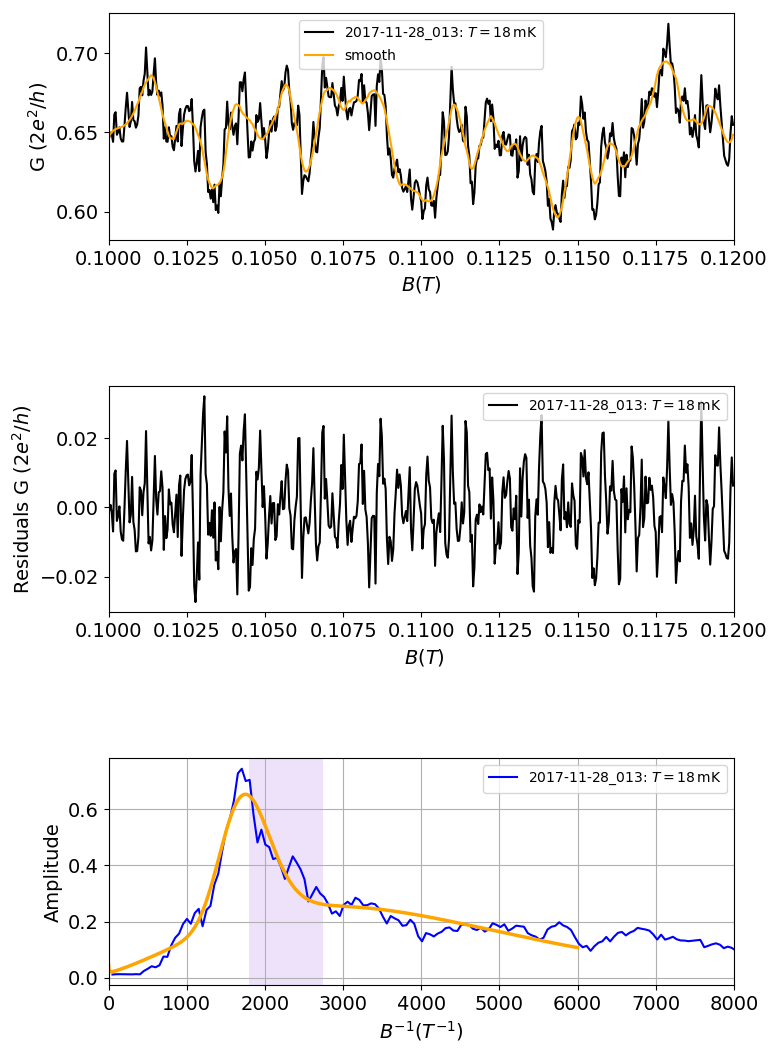

In [137]:
#Test
inputFile_1 = 'D:\\data\\2017-11-28\\2017-11-28_013.dat'
inputFiles = [inputFile_1]
column_B = 0
column_G = 5
R_lines = 28e3
V_AC = 10e-6
labels =  ['2017-11-28_013: $T = 18\,$mK'] 
windows = [41]
orders = [4]


plot_name = 'SAG_loop1'
#B_min = 0.005
#B_max = 0.125

B_min = 0.100
B_max = 0.120

T = '18 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT

magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders,  
                                          labels, plot_name, A_min, A_center, A_max, B_min, B_max, 
                                          order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window,
                                          plot = True , fitting = True, bandpass = False, smooth_fft = True, 
                                          locked_fit = True, only_fft = False);

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes_env2\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: overflow encountered in exp
C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes_env2\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: invalid value encountered in add


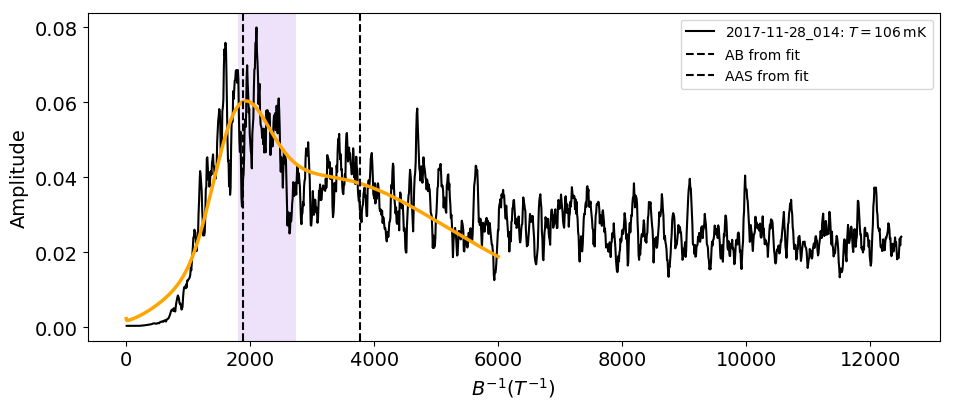

In [474]:
inputFile_1 = 'D:\\data\\2017-11-28\\2017-11-28_014.dat'
inputFiles = [inputFile_1]
labels =  ['2017-11-28_014: $T = 106\,$mK'] 
windows = [37]
orders = [4]

plot_name = 'SAG'
B_min = 0.005
B_max = 0.125

T = '106 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT


#magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, \
#                                             B_min, B_max);
#magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max);

magnetoconductance_range_special_bandpass(inputFiles, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, \
                                          plot = True, fitting = True, bandpass = False, smooth_fft = True, \
                                          locked_fit = True, only_fft = True);

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes_env2\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: overflow encountered in exp


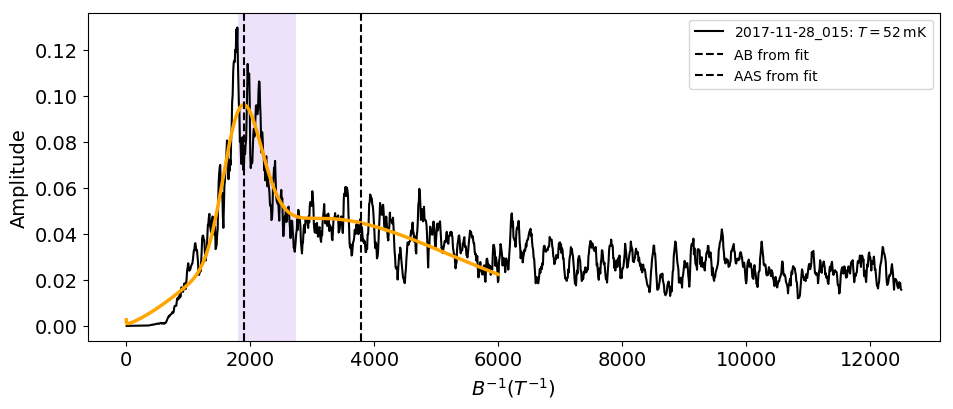

In [477]:
inputFile_1 = 'D:\\data\\2017-11-28\\2017-11-28_015.dat'
inputFiles = [inputFile_1]
labels =  ['2017-11-28_015: $T = 52\,$mK'] 
windows = [37]
orders = [4]

plot_name = 'SAG'
B_min = 0.005
B_max = 0.125

T = '52 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT


#magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, \
#                                             B_min, B_max);
#magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max);

magnetoconductance_range_special_bandpass(inputFiles, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, \
                                          plot = True, fitting = True, bandpass = False, smooth_fft = True, \
                                          locked_fit = True, only_fft = True);

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes_env2\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: overflow encountered in exp


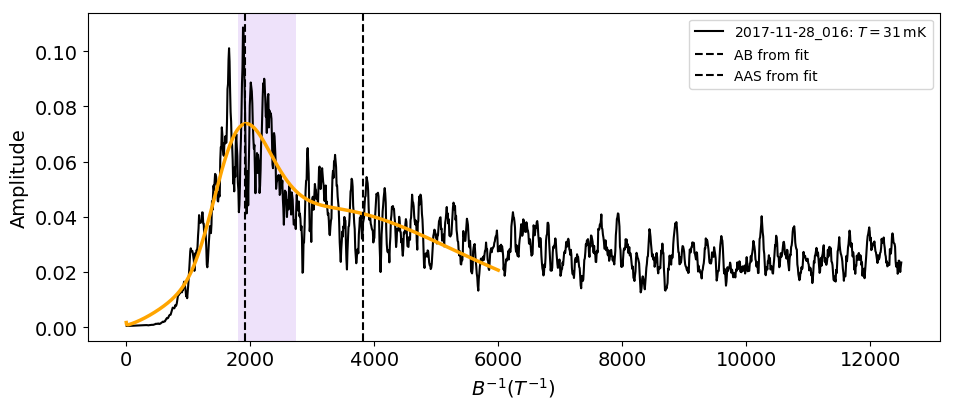

In [478]:
inputFile_1 = 'D:\\data\\2017-11-28\\2017-11-28_016.dat'
inputFiles = [inputFile_1]
labels =  ['2017-11-28_016: $T = 31\,$mK'] 
windows = [37]
orders = [4]

plot_name = 'SAG'
B_min = 0.005
B_max = 0.125

T = '31 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT


#magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, \
#                                             B_min, B_max);
#magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max);

magnetoconductance_range_special_bandpass(inputFiles, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, \
                                          plot = True, fitting = True, bandpass = False, smooth_fft = True, \
                                          locked_fit = True, only_fft = True);

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes_env2\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: overflow encountered in exp
C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes_env2\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: invalid value encountered in add


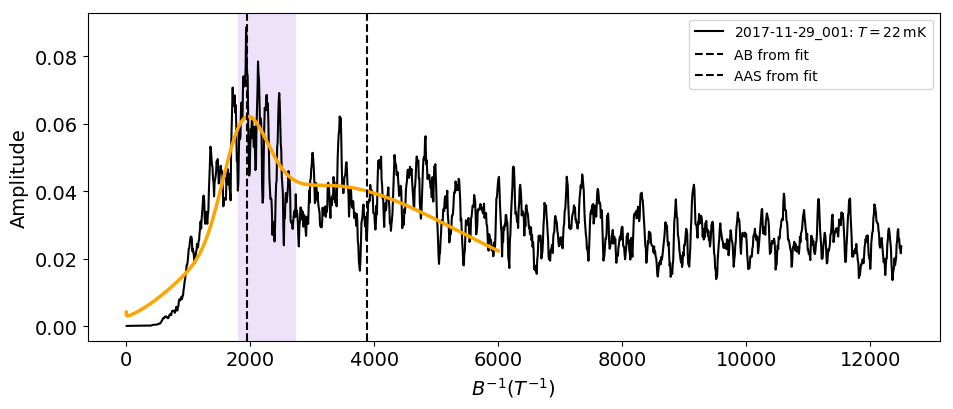

In [492]:
inputFile_1 = 'D:\\data\\2017-11-29\\2017-11-29_001.dat'
inputFiles = [inputFile_1]
labels =  ['2017-11-29_001: $T = 22\,$mK'] 
windows = [37]
orders = [4]

plot_name = 'SAG'
B_min = 0.005
B_max = 0.125

T = '22 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT


#magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, \
#                                             B_min, B_max);
#magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max);

magnetoconductance_range_special_bandpass(inputFiles, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, \
                                          plot = True, fitting = True, bandpass = False, smooth_fft = True, \
                                          locked_fit = True, only_fft = True);

C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes_env2\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: overflow encountered in exp
C:\Users\LocalAdmin\AppData\Local\conda\conda\envs\qcodes_env2\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: overflow encountered in multiply


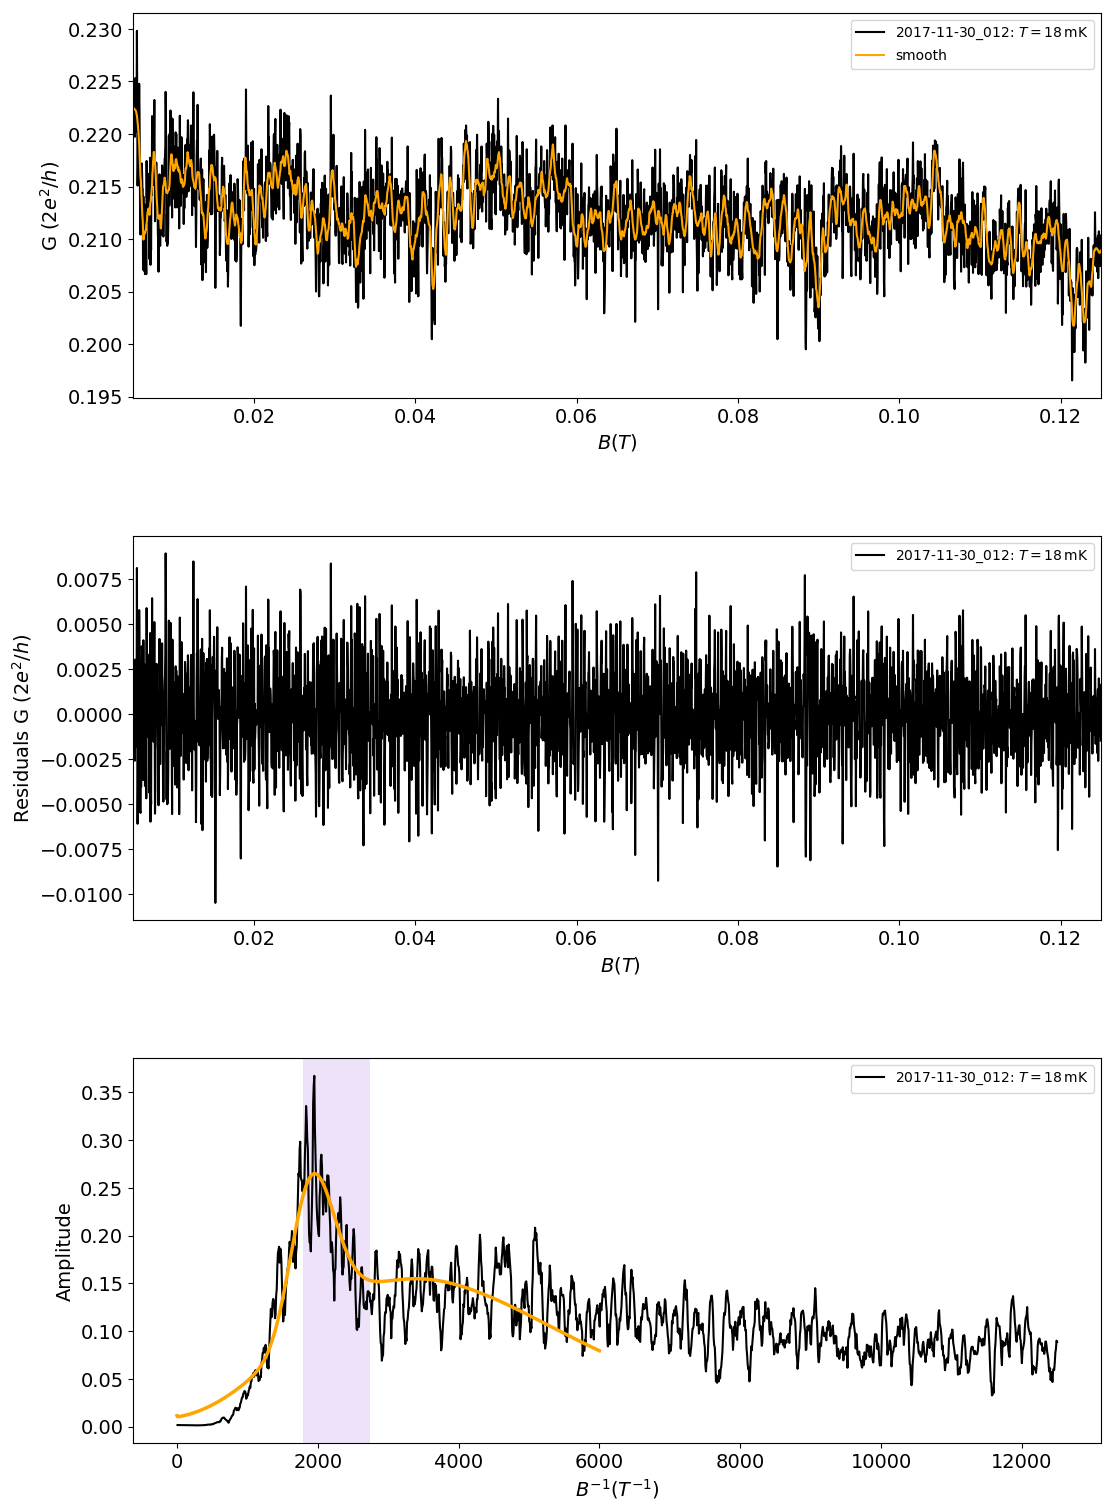

In [498]:
inputFile_1 = 'D:\\data\\2017-11-30\\2017-11-30_012.dat'
inputFiles = [inputFile_1]
labels =  ['2017-11-30_012: $T = 18\,$mK'] 
windows = [37]
orders = [4]

plot_name = 'SAG'
B_min = 0.005
B_max = 0.125

T = '18 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT


#magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, \
#                                             B_min, B_max);
#magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max);

magnetoconductance_range_special_bandpass(inputFiles, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, \
                                          plot = True, fitting = True, bandpass = False, smooth_fft = True, \
                                          locked_fit = True, only_fft = False);

## Example 1

In [285]:
inputFile_1 = 'D:\\data\\2017-11-30\\2017-11-30_039.dat'
inputFiles = [inputFile_1]

column_B = 0
column_G = 5
R_lines = 18e3
V_AC = 10e-6

labels =  ['2017-11-30_039: $T = 18\,$mK'] 
windows = [23]
orders = [3]

plot_name = 'q0023_example1'
#B_min = 0.005
#B_max = 0.125

B_min = 0.09
B_max = 0.094


T = '18 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT


#magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, \
#                                             B_min, B_max);
#magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max);


a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, 
                                            f_max = 12000, angle_correction = True, smooth_data = True, \
                                          plot = True, fitting = False, bandpass = False, smooth_fft = False, \
                                          locked_fit = True, only_fft = False);

TypeError: Improper input: N=6 must not exceed M=3

In [283]:
inputFile_1 = 'D:\\data\\2017-11-30\\2017-11-30_039.dat'
inputFiles = [inputFile_1]

column_B = 0
column_G = 5
R_lines = 18e3
V_AC = 10e-6

labels =  ['2017-11-30_039: $T = 18\,$mK'] 
windows = [23]
orders = [3]

plot_name = 'q0023_example2'
#B_min = 0.005
#B_max = 0.125

B_min = 0.09
B_max = 0.094


T = '18 mK'
A_min = 7.43 #7.63
A_max = 11.34
A_center = 9.3 #9.44

order_filter = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 15 #smooth window for FFT


#magnetconductance_average_special_singlepeak(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, \
#                                             B_min, B_max);
#magnetconductance_average_special(inputFiles, windows, orders, labels, T, plot_name, A_min, A_center, A_max, B_min, B_max);


a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, 
                                            f_max = 10000, angle_correction = True, smooth_data = True, \
                                          plot = True, fitting = True, bandpass = False, smooth_fft = True, \
                                          locked_fit = True, only_fft = False)

TypeError: Improper input: N=6 must not exceed M=3

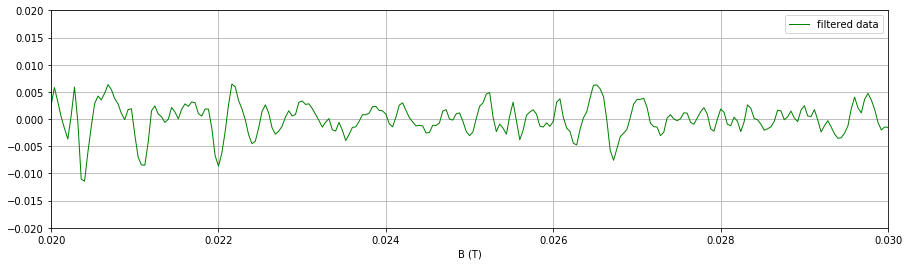

In [132]:
inputfile1  = 'D:\\data\\2017-11-28\\2017-11-28_013.dat'

data1 = np.loadtxt(inputfile1)

B = data1[:,0]
G = data1[:,5]/10*12906

# def butter_lowpass(low, high, fs, order=5):
#     nyq = 0.5 * fs
#     cutoff_low = low / nyq
#     cutoff_high = high / nyq
#     b, a = butter(order, [cutoff_low, cutoff_high], btype='band', analog=False)
#     return b, a

# def butter_lowpass_filter(data, low, high, fs, order=5):
#     b, a = butter_lowpass(low, high, fs, order=order)
#     y = lfilter(b, a, data)
#     return y

# Filter requirements.
order = 6
fs = 25000     # sample rate, Hz
highpass_cutoff = 1000  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

# Filter the data, and plot both the original and filtered signals.
y = butter_bandpass_filter(G, highpass_cutoff, lowpass_cutoff, fs, order)

plt.figure(figsize=(15,4))
#plt.plot(B[5:], G[5:], 'b-', label='data')
plt.plot(B[40:], y[40:], 'g-', linewidth=1, label='filtered data')
plt.xlabel('B (T)')
axes = plt.gca()
axes.set_xlim([0.02,0.03])
axes.set_ylim([-0.02,0.02])
plt.grid()
plt.legend()

# SAG Q0052 D1 

## Loop 4 

([], [])

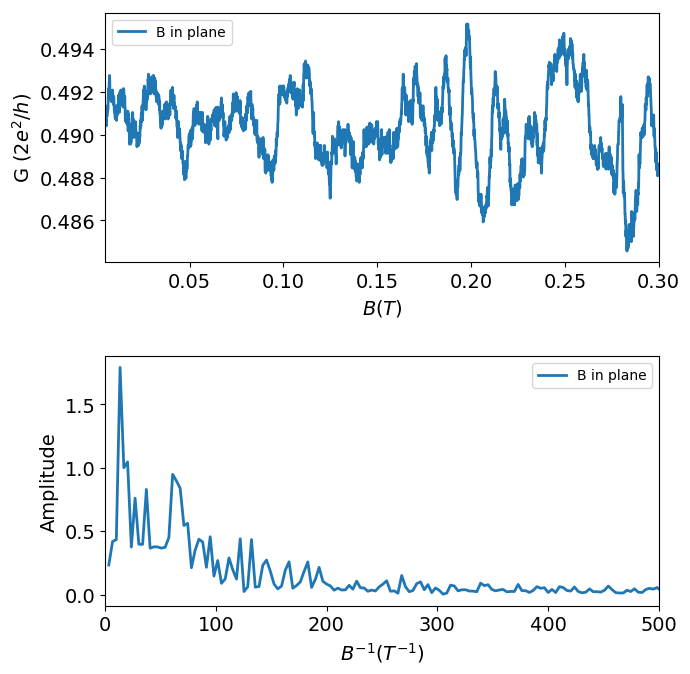

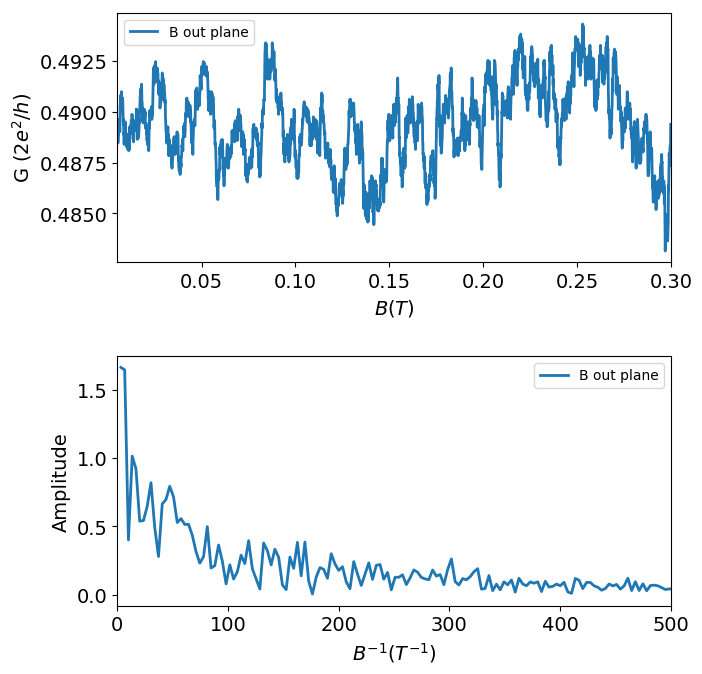

In [16]:
inputFile_inplane = 'D:\\data\\2018-01-20\\2018-01-20_001.dat'
inputFile_outplane = 'D:\\data\\2018-01-19\\2018-01-19_011.dat'

inputFiles = [inputFile_inplane]
labels =  ['B in plane']
windows = [3]
#105
orders = [2]
plot_name = 'inplane_loop4'
B_min = 0.005
B_max = 0.300
#magnetoconductance_range(inputFiles, windows, orders, labels,  plot_name, B_min, B_max, plot=True, fitting = False);
magnetoconductance_range_FFT(inputFiles,  labels, plot_name, B_min, B_max, plot = True )

inputFiles = [inputFile_outplane]
labels =  ['B out plane']
windows = [3]
#105
orders = [2]
plot_name = 'outplane_loop4'
B_min = 0.005
B_max = 0.300
#magnetoconductance_range(inputFiles, windows, orders, labels,  plot_name, B_min, B_max, plot=True, fitting = False);
magnetoconductance_range_FFT(inputFiles,  labels, plot_name, B_min, B_max, plot = True )

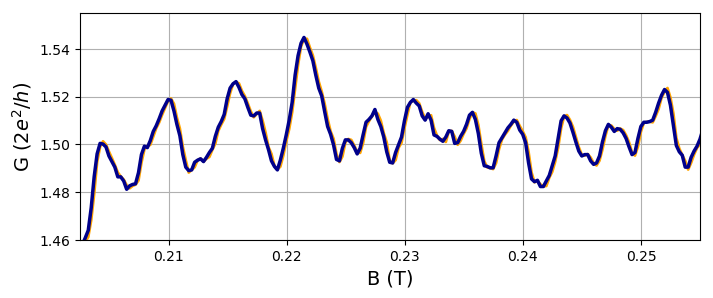

In [181]:
inputFile1 ='D:\\data\\2018-01-18\\2018-01-18_011.dat'
data = np.loadtxt(inputFile1)
column = 5
R_lines = 18e3                      #in ohm
ex = 25                             #excitation lockin in uV
B = np.array(data[1:,0])
G = np.array(data[1:,column])/ex    #in Siemens 
G = G/(1. - R_lines*G)              # correction for line resistance
G = 12906*G
Gsmoothed = savgol_filter(G, 5, 3)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

fig = plt.figure(figsize=(8,3))
#plt.plot(B, G, linewidth=2, color='darkblue')
plt.plot(B, Gsmoothed, linewidth=2, color='orange')
plt.plot(B, smooth(G,2), linewidth=2.5, color='darkblue')
plt.xlabel('B (T)', fontsize = axes_font)
plt.ylabel('G ($ 2e^2/h$)', fontsize = axes_font)
plt.xlim(0.2025,0.255)
plt.ylim(1.46,1.555)
plt.grid(True)
fig.savefig('loop4_SAGQ0052.pdf',format='pdf',transparent = False, bbox_inches='tight')



FileNotFoundError: [Errno 2] No such file or directory: 'plots//loop4_SAGQ0052_gate.png'

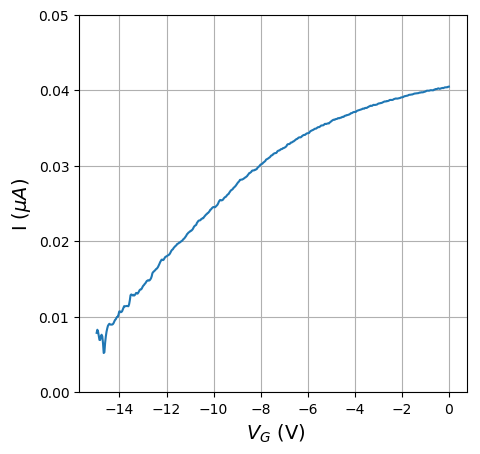

In [257]:
inputFile1 ='D:\\data\\2018-01-16\\2018-01-16_034.dat'
data = np.loadtxt(inputFile1)
column = 3
R_lines = 18e3                      #in ohm
V_g = np.array(data[1:,0])*15/1000
I = np.array(data[1:,column])       #uV

fig = plt.figure(figsize=(5,5))
plt.plot(V_g, I)
plt.xlabel(' $ V_G $ (V)', fontsize = axes_font)
plt.ylabel('I ($  \mu A $)', fontsize = axes_font)
plt.grid(True)
plt.ylim(0,0.05)
fig.savefig('plots//loop4_SAGQ0052_gate.png',format='png',transparent = False, bbox_inches='tight')

D:\pycharmprojects\insects\analysis.py:160: RuntimeWarning: overflow encountered in exp
  y =  offset + A1*np.exp(-B1*(np.sqrt(x)-np.sqrt(x1))**2)*x**(-0.5) + A2*np.exp(-B2*(np.sqrt(x)-np.sqrt(2*x1))**2)*x**(-0.5)


([array([   14.32313207,    28.64626413,    42.9693962 ,    57.29252826,
            71.61566033,    85.93879239,   100.26192446,   114.58505652,
           128.90818859,   143.23132065,   157.55445272,   171.87758478,
           186.20071685,   200.52384891,   214.84698098,   229.17011304,
           243.49324511,   257.81637717,   272.13950924,   286.4626413 ,
           300.78577337,   315.10890543,   329.4320375 ,   343.75516956,
           358.07830163,   372.40143369,   386.72456576,   401.04769782,
           415.37082989,   429.69396195,   444.01709402,   458.34022608,
           472.66335815,   486.98649021,   501.30962228,   515.63275434,
           529.95588641,   544.27901847,   558.60215054,   572.9252826 ,
           587.24841467,   601.57154673,   615.8946788 ,   630.21781086,
           644.54094293,   658.86407499,   673.18720706,   687.51033912,
           701.83347119,   716.15660325,   730.47973532,   744.80286738,
           759.12599945,   773.44913151,   787.7722

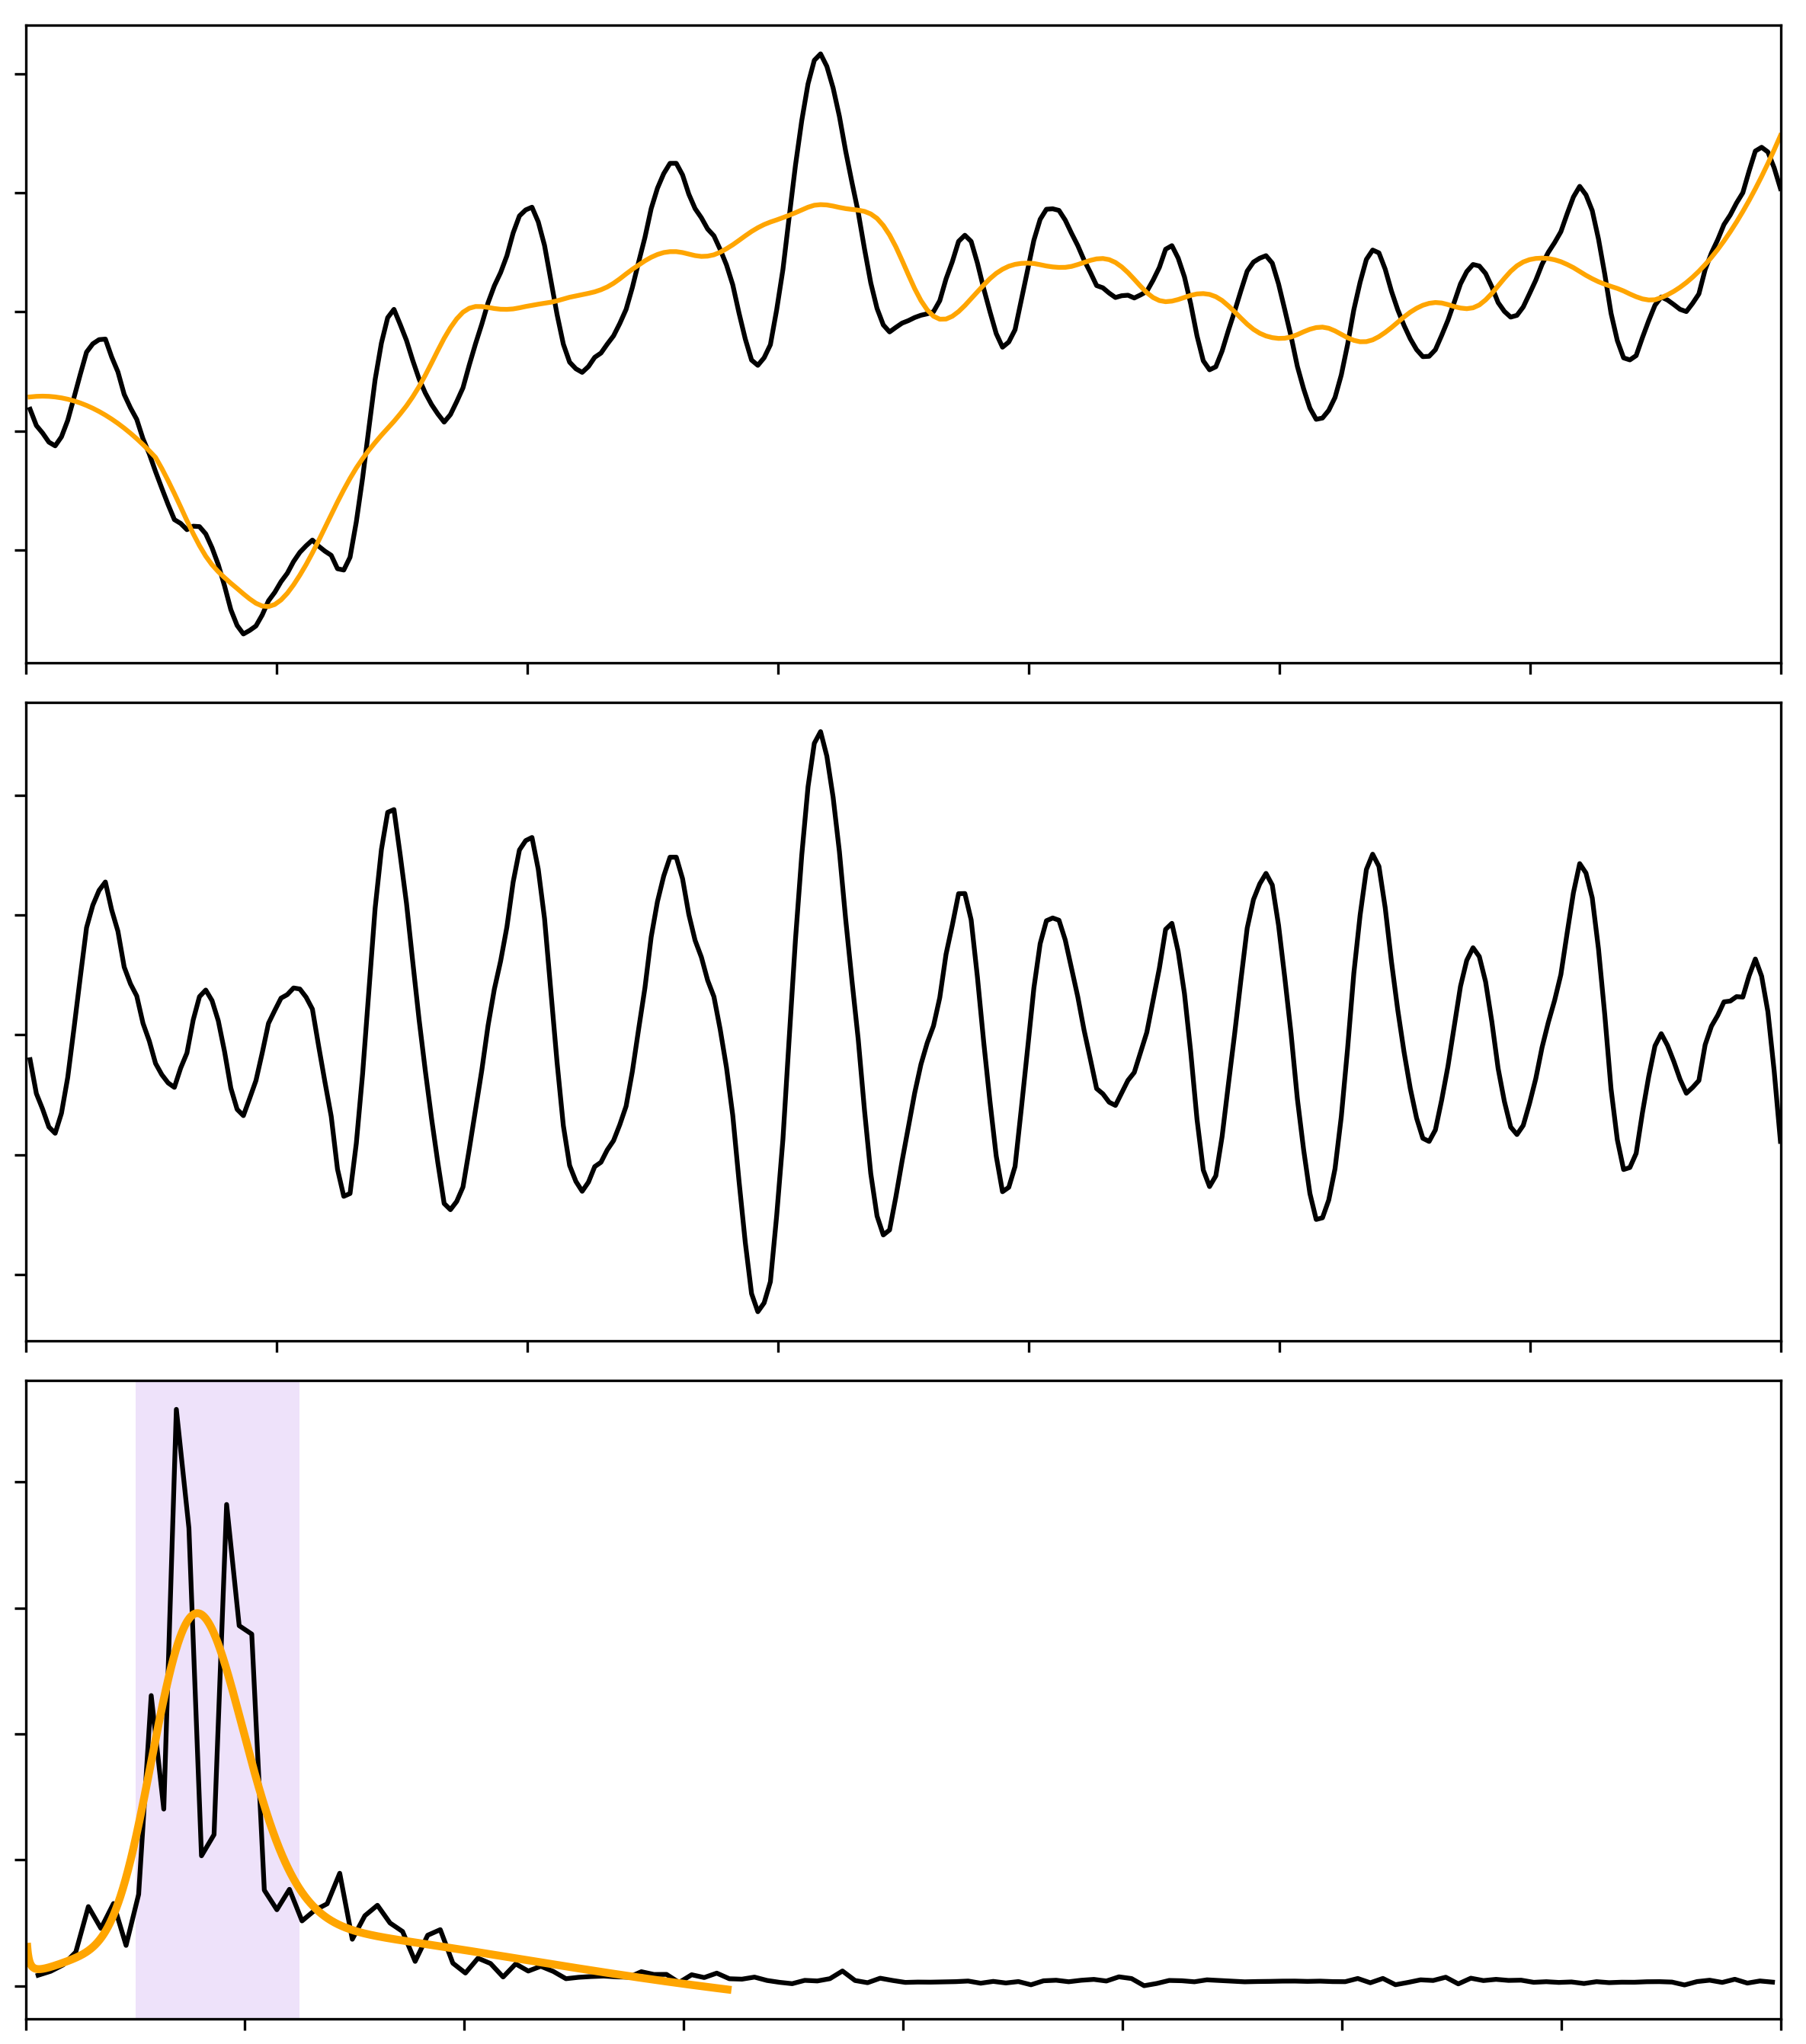

In [281]:
inputFile_1 = 'D:\\data\\2018-01-18\\2018-01-18_011.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-18_011'] 
windows = [41]
orders = [2]
column_B = 0
column_G = 5
R_lines = 18e3
V_AC = 25e-6
plot_name = 'fft_loop4'
B_min = 0.190
B_max = 0.260
T = '18 mK'
A_min = 0.52 #0.599
A_max = 1.29 #1.33
A_center = 0.9 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT



a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, 
                                            f_max = 2000, angle_correction = False, smooth_data = True,  plot = True, fitting = True, 
                                            bandpass = False, smooth_fft = False, locked_fit = True, only_fft = False)


##Gate sweep on loop 4

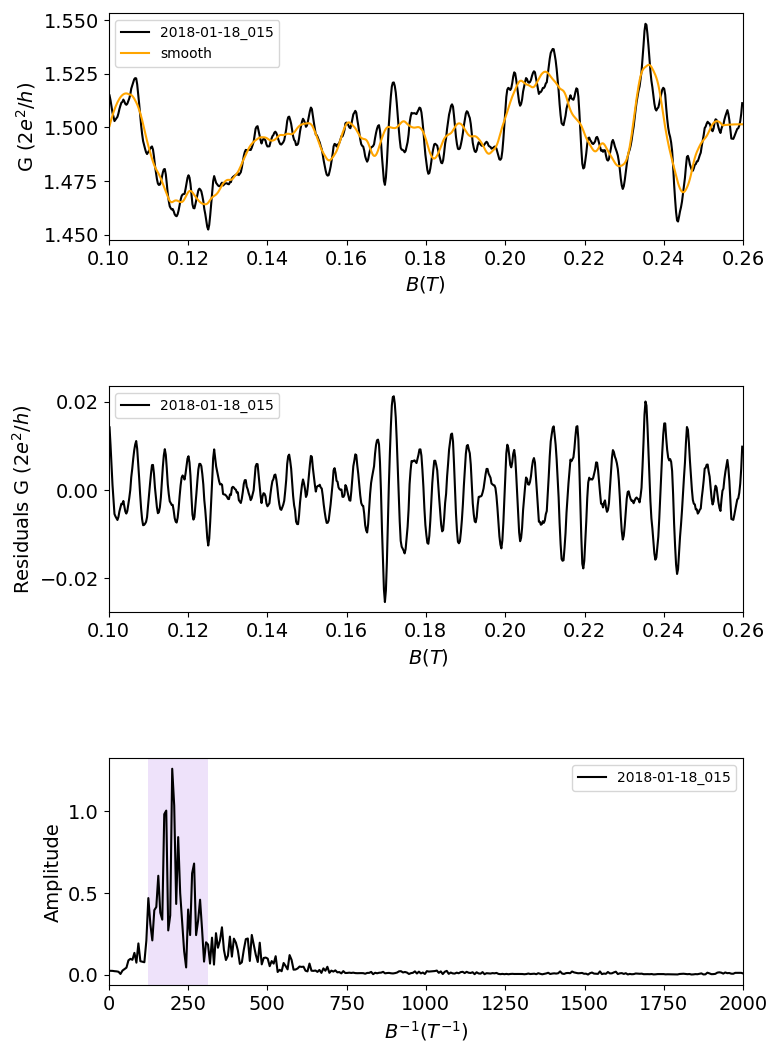

In [190]:
#VG = 0 
inputFile_1 = 'D:\\data\\2018-01-18\\2018-01-18_015.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-18_015'] 
windows = [41]
orders = [2]
column_B = 0
column_G = 4
R_lines = 18e3
V_AC = 25e-6
plot_name = 'V_G=0'
B_min = 0.1
B_max = 0.260
T = '18 mK'
A_min = 0.52 #0.599
A_max = 1.29 #1.33
A_center = 0.9 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT



a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, smooth_data = True, \
                                          plot = True, fitting = False, bandpass = False, smooth_fft = False, \
                                          locked_fit = True, only_fft = False);


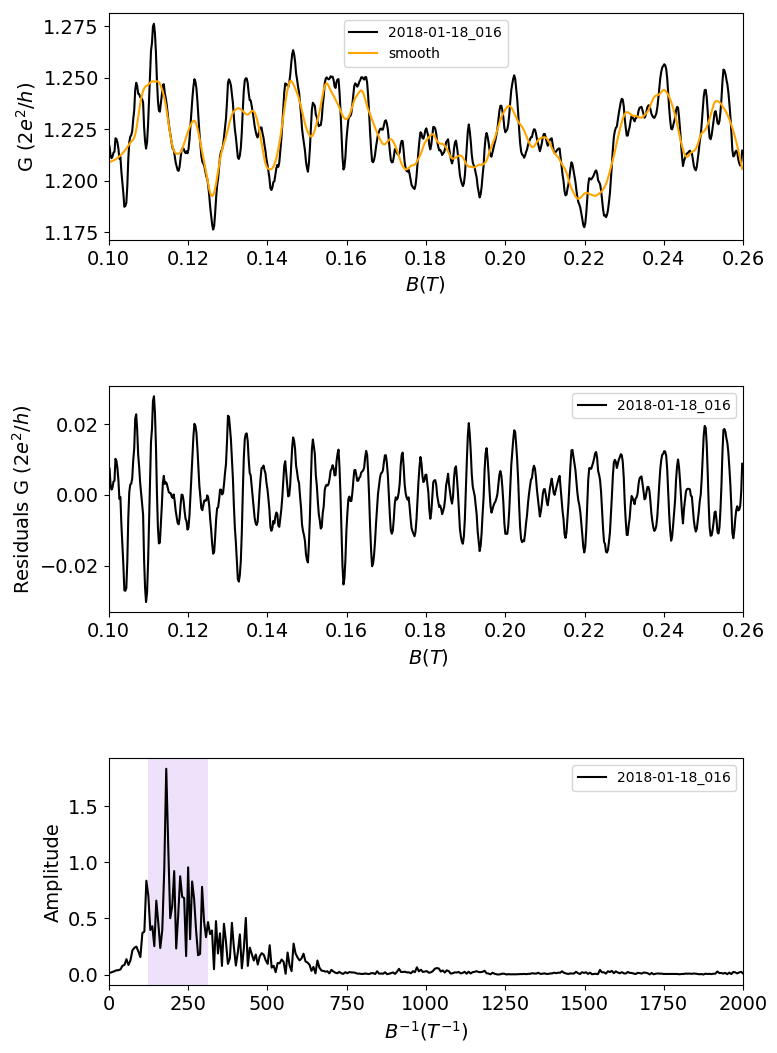

In [192]:
#VG = - 1650
inputFile_1 = 'D:\\data\\2018-01-18\\2018-01-18_016.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-18_016'] 
windows = [41]
orders = [2]
column_B = 0
column_G = 4
R_lines = 18e3
V_AC = 25e-6
plot_name = 'V_G=-1650'
B_min = 0.1
B_max = 0.260
T = '18 mK'
A_min = 0.52 #0.599
A_max = 1.29 #1.33
A_center = 0.9 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT



a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, smooth_data = True, \
                                          plot = True, fitting = False, bandpass = False, smooth_fft = False, \
                                          locked_fit = True, only_fft = False);

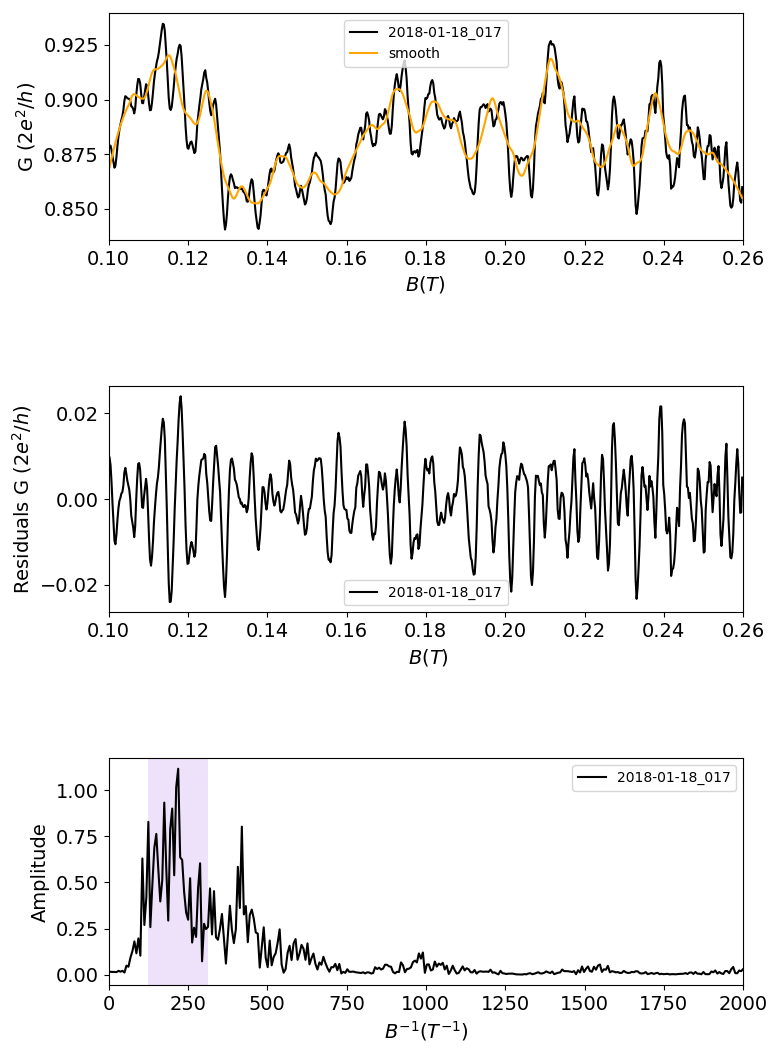

In [194]:
#VG = - 3300
inputFile_1 = 'D:\\data\\2018-01-18\\2018-01-18_017.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-18_017'] 
windows = [41]
orders = [2]
column_B = 0
column_G = 4
R_lines = 18e3
V_AC = 25e-6
plot_name = 'V_G=-3300'
B_min = 0.1
B_max = 0.260
T = '18 mK'
A_min = 0.52 #0.599
A_max = 1.29 #1.33
A_center = 0.9 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT



a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, smooth_data = True, \
                                          plot = True, fitting = False, bandpass = False, smooth_fft = False, \
                                          locked_fit = True, only_fft = False);

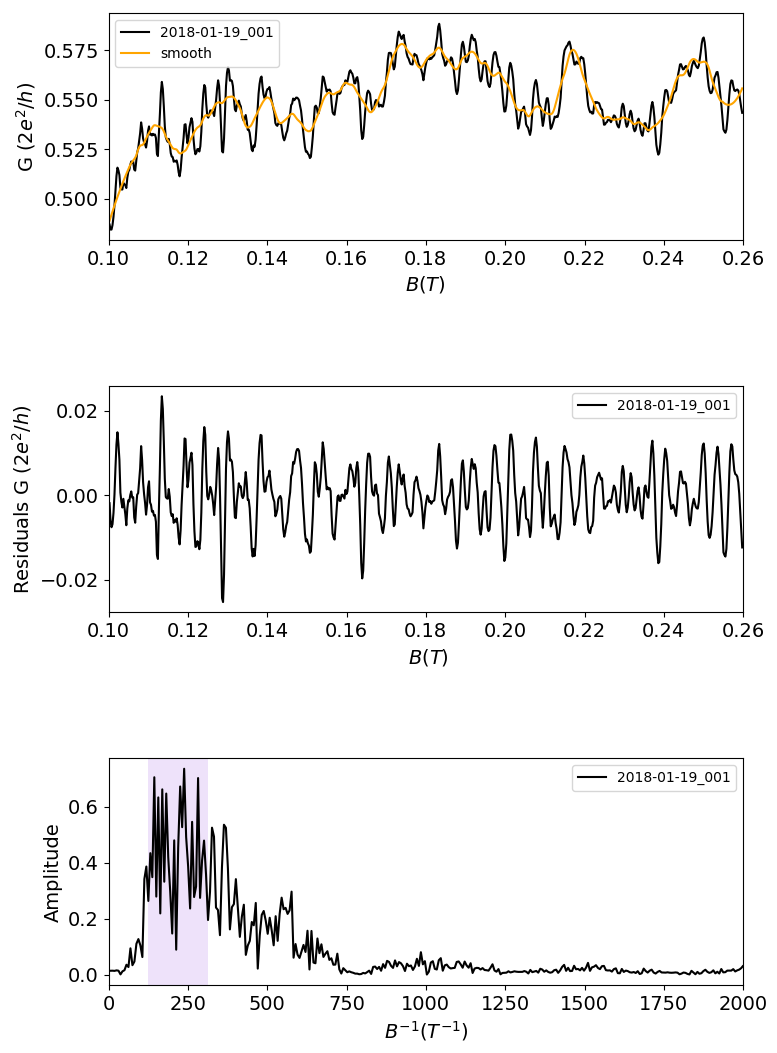

In [196]:
#VG = - 4950
inputFile_1 = 'D:\\data\\2018-01-19\\2018-01-19_001.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-19_001'] 
windows = [41]
orders = [2]
column_B = 0
column_G = 4
R_lines = 18e3
V_AC = 25e-6
plot_name = 'V_G=-4950'
B_min = 0.1
B_max = 0.260
T = '18 mK'
A_min = 0.52 #0.599
A_max = 1.29 #1.33
A_center = 0.9 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT



a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, smooth_data = True, \
                                          plot = True, fitting = False, bandpass = False, smooth_fft = False, \
                                          locked_fit = True, only_fft = False);

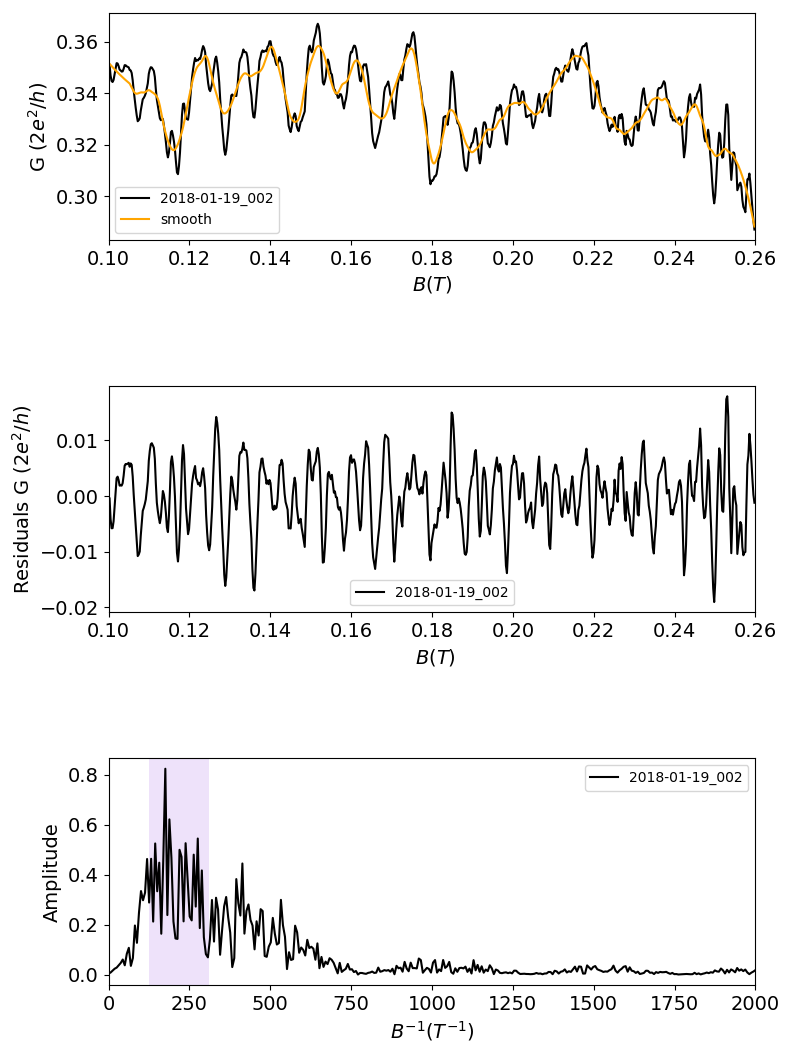

In [197]:
#VG = - 6600
inputFile_1 = 'D:\\data\\2018-01-19\\2018-01-19_002.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-19_002'] 
windows = [41]
orders = [2]
column_B = 0
column_G = 4
R_lines = 18e3
V_AC = 25e-6
plot_name = 'V_G=-6600'
B_min = 0.1
B_max = 0.260
T = '18 mK'
A_min = 0.52 #0.599
A_max = 1.29 #1.33
A_center = 0.9 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT



a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, smooth_data = True, \
                                          plot = True, fitting = False, bandpass = False, smooth_fft = False, \
                                          locked_fit = True, only_fft = False);

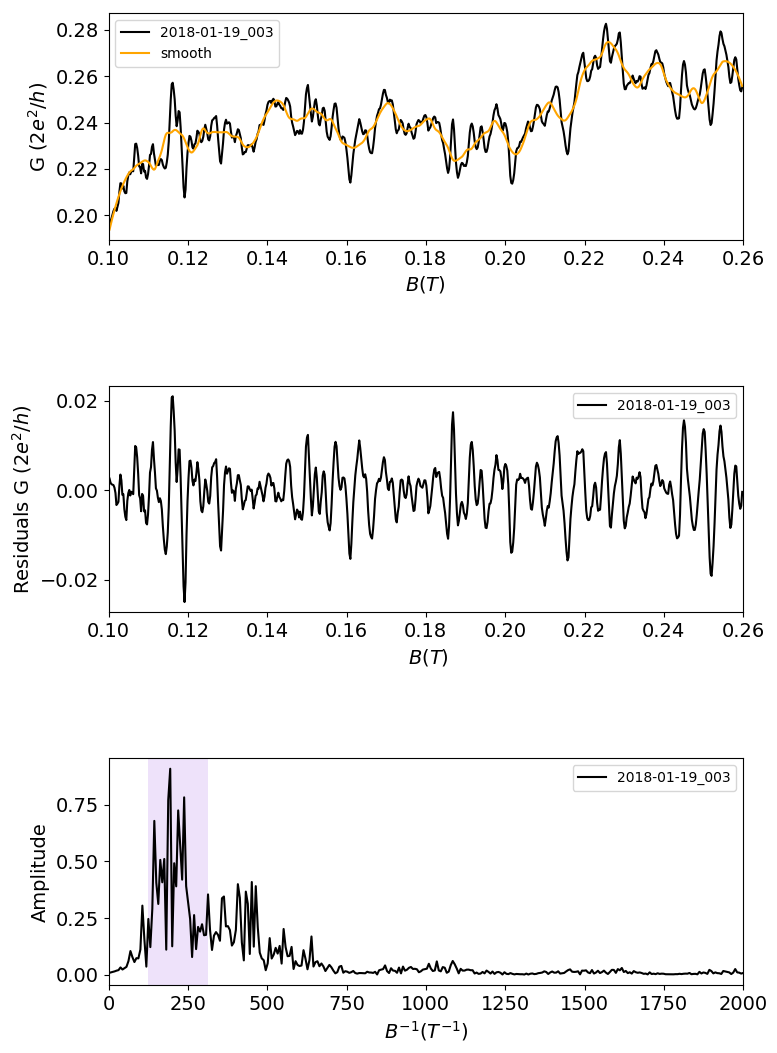

In [199]:
#VG = - 8250
inputFile_1 = 'D:\\data\\2018-01-19\\2018-01-19_003.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-19_003'] 
windows = [41]
orders = [2]
column_B = 0
column_G = 4
R_lines = 18e3
V_AC = 25e-6
plot_name = 'V_G=-8250'
B_min = 0.1
B_max = 0.260
T = '18 mK'
A_min = 0.52 #0.599
A_max = 1.29 #1.33
A_center = 0.9 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT



a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, smooth_data = True, \
                                          plot = True, fitting = False, bandpass = False, smooth_fft = False, \
                                          locked_fit = True, only_fft = False);

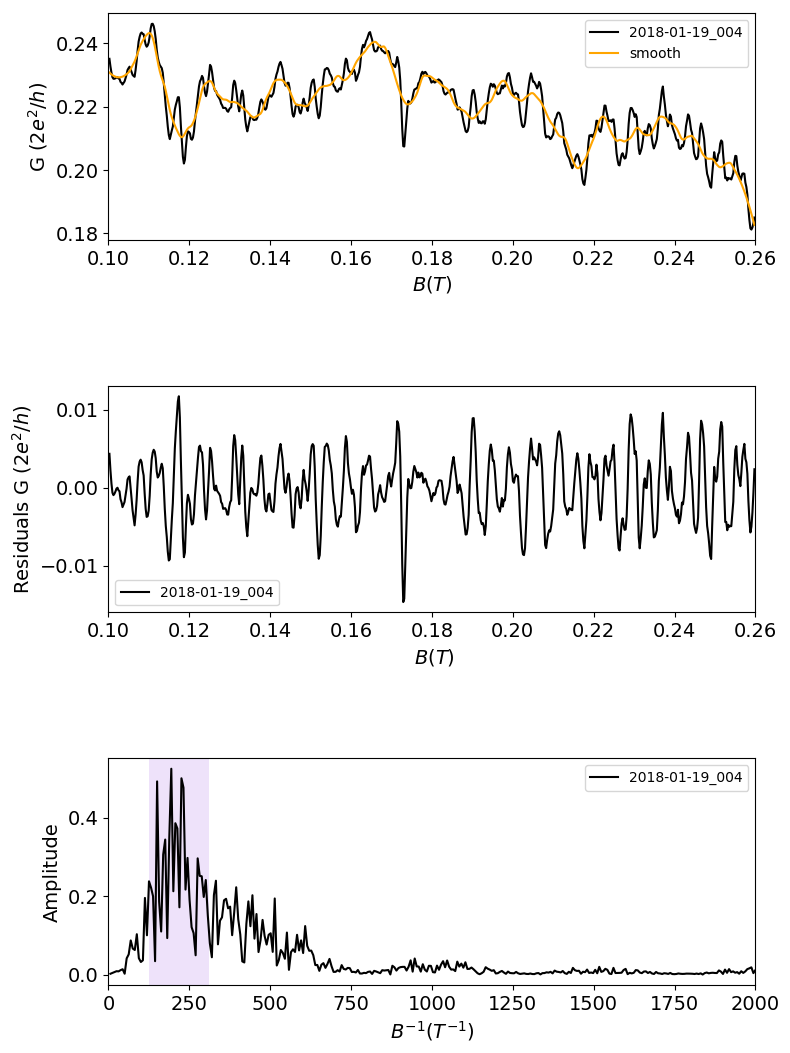

In [200]:
#VG = - 9900
inputFile_1 = 'D:\\data\\2018-01-19\\2018-01-19_004.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-19_004'] 
windows = [41]
orders = [2]
column_B = 0
column_G = 4
R_lines = 18e3
V_AC = 25e-6
plot_name = 'V_G=-9900'
B_min = 0.1
B_max = 0.260
T = '18 mK'
A_min = 0.52 #0.599
A_max = 1.29 #1.33
A_center = 0.9 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT



a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name, A_min, A_center, A_max, \
                                          B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff, smooth_window, smooth_data = True, \
                                          plot = True, fitting = False, bandpass = False, smooth_fft = False, \
                                          locked_fit = True, only_fft = False);

## Loop 6

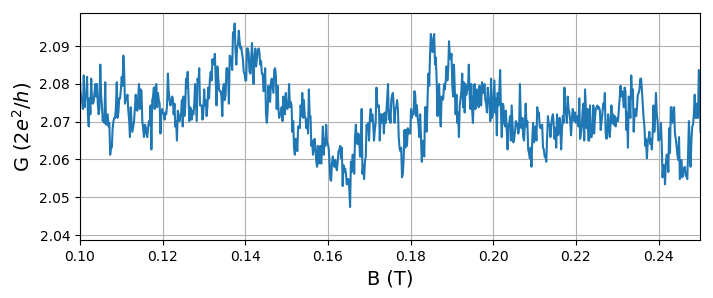

In [99]:
inputFile1 ='D:\\data\\2018-01-17\\2018-01-17_028.dat'
data = np.loadtxt(inputFile1)
column = 3
R_lines = 18*1000                      #in ohm
ex = 25                            #excitation lockin in uV
B = np.array(data[1:,0])
G = np.array(data[1:,column])/ex    #in Siemens 
G = G/(1. - R_lines*G)              # correction for line resistance
G = 12906*G

fig = plt.figure(figsize=(8,3))
plt.plot(B, G)
plt.xlabel('B (T)', fontsize = axes_font)
plt.ylabel('G ($ 2e^2/h$)', fontsize = axes_font)
plt.grid(True)
plt.xlim(0.1, 0.25)
fig.savefig('plots//loop6_SAGQ0052.png',format='png',transparent = False, bbox_inches='tight')

D:\pycharmprojects\insects\analysis.py:160: RuntimeWarning: invalid value encountered in sqrt
  y =  offset + A1*np.exp(-B1*(np.sqrt(x)-np.sqrt(x1))**2)*x**(-0.5) + A2*np.exp(-B2*(np.sqrt(x)-np.sqrt(2*x1))**2)*x**(-0.5)
D:\pycharmprojects\insects\analysis.py:160: RuntimeWarning: overflow encountered in exp
  y =  offset + A1*np.exp(-B1*(np.sqrt(x)-np.sqrt(x1))**2)*x**(-0.5) + A2*np.exp(-B2*(np.sqrt(x)-np.sqrt(2*x1))**2)*x**(-0.5)


([array([    6.67484359,    13.34968717,    20.02453076,    26.69937435,
            33.37421793,    40.04906152,    46.72390511,    53.39874869,
            60.07359228,    66.74843587,    73.42327945,    80.09812304,
            86.77296663,    93.44781022,   100.1226538 ,   106.79749739,
           113.47234098,   120.14718456,   126.82202815,   133.49687174,
           140.17171532,   146.84655891,   153.5214025 ,   160.19624608,
           166.87108967,   173.54593326,   180.22077684,   186.89562043,
           193.57046402,   200.2453076 ,   206.92015119,   213.59499478,
           220.26983836,   226.94468195,   233.61952554,   240.29436912,
           246.96921271,   253.6440563 ,   260.31889989,   266.99374347,
           273.66858706,   280.34343065,   287.01827423,   293.69311782,
           300.36796141,   307.04280499,   313.71764858,   320.39249217,
           327.06733575,   333.74217934,   340.41702293,   347.09186651,
           353.7667101 ,   360.44155369,   367.1163

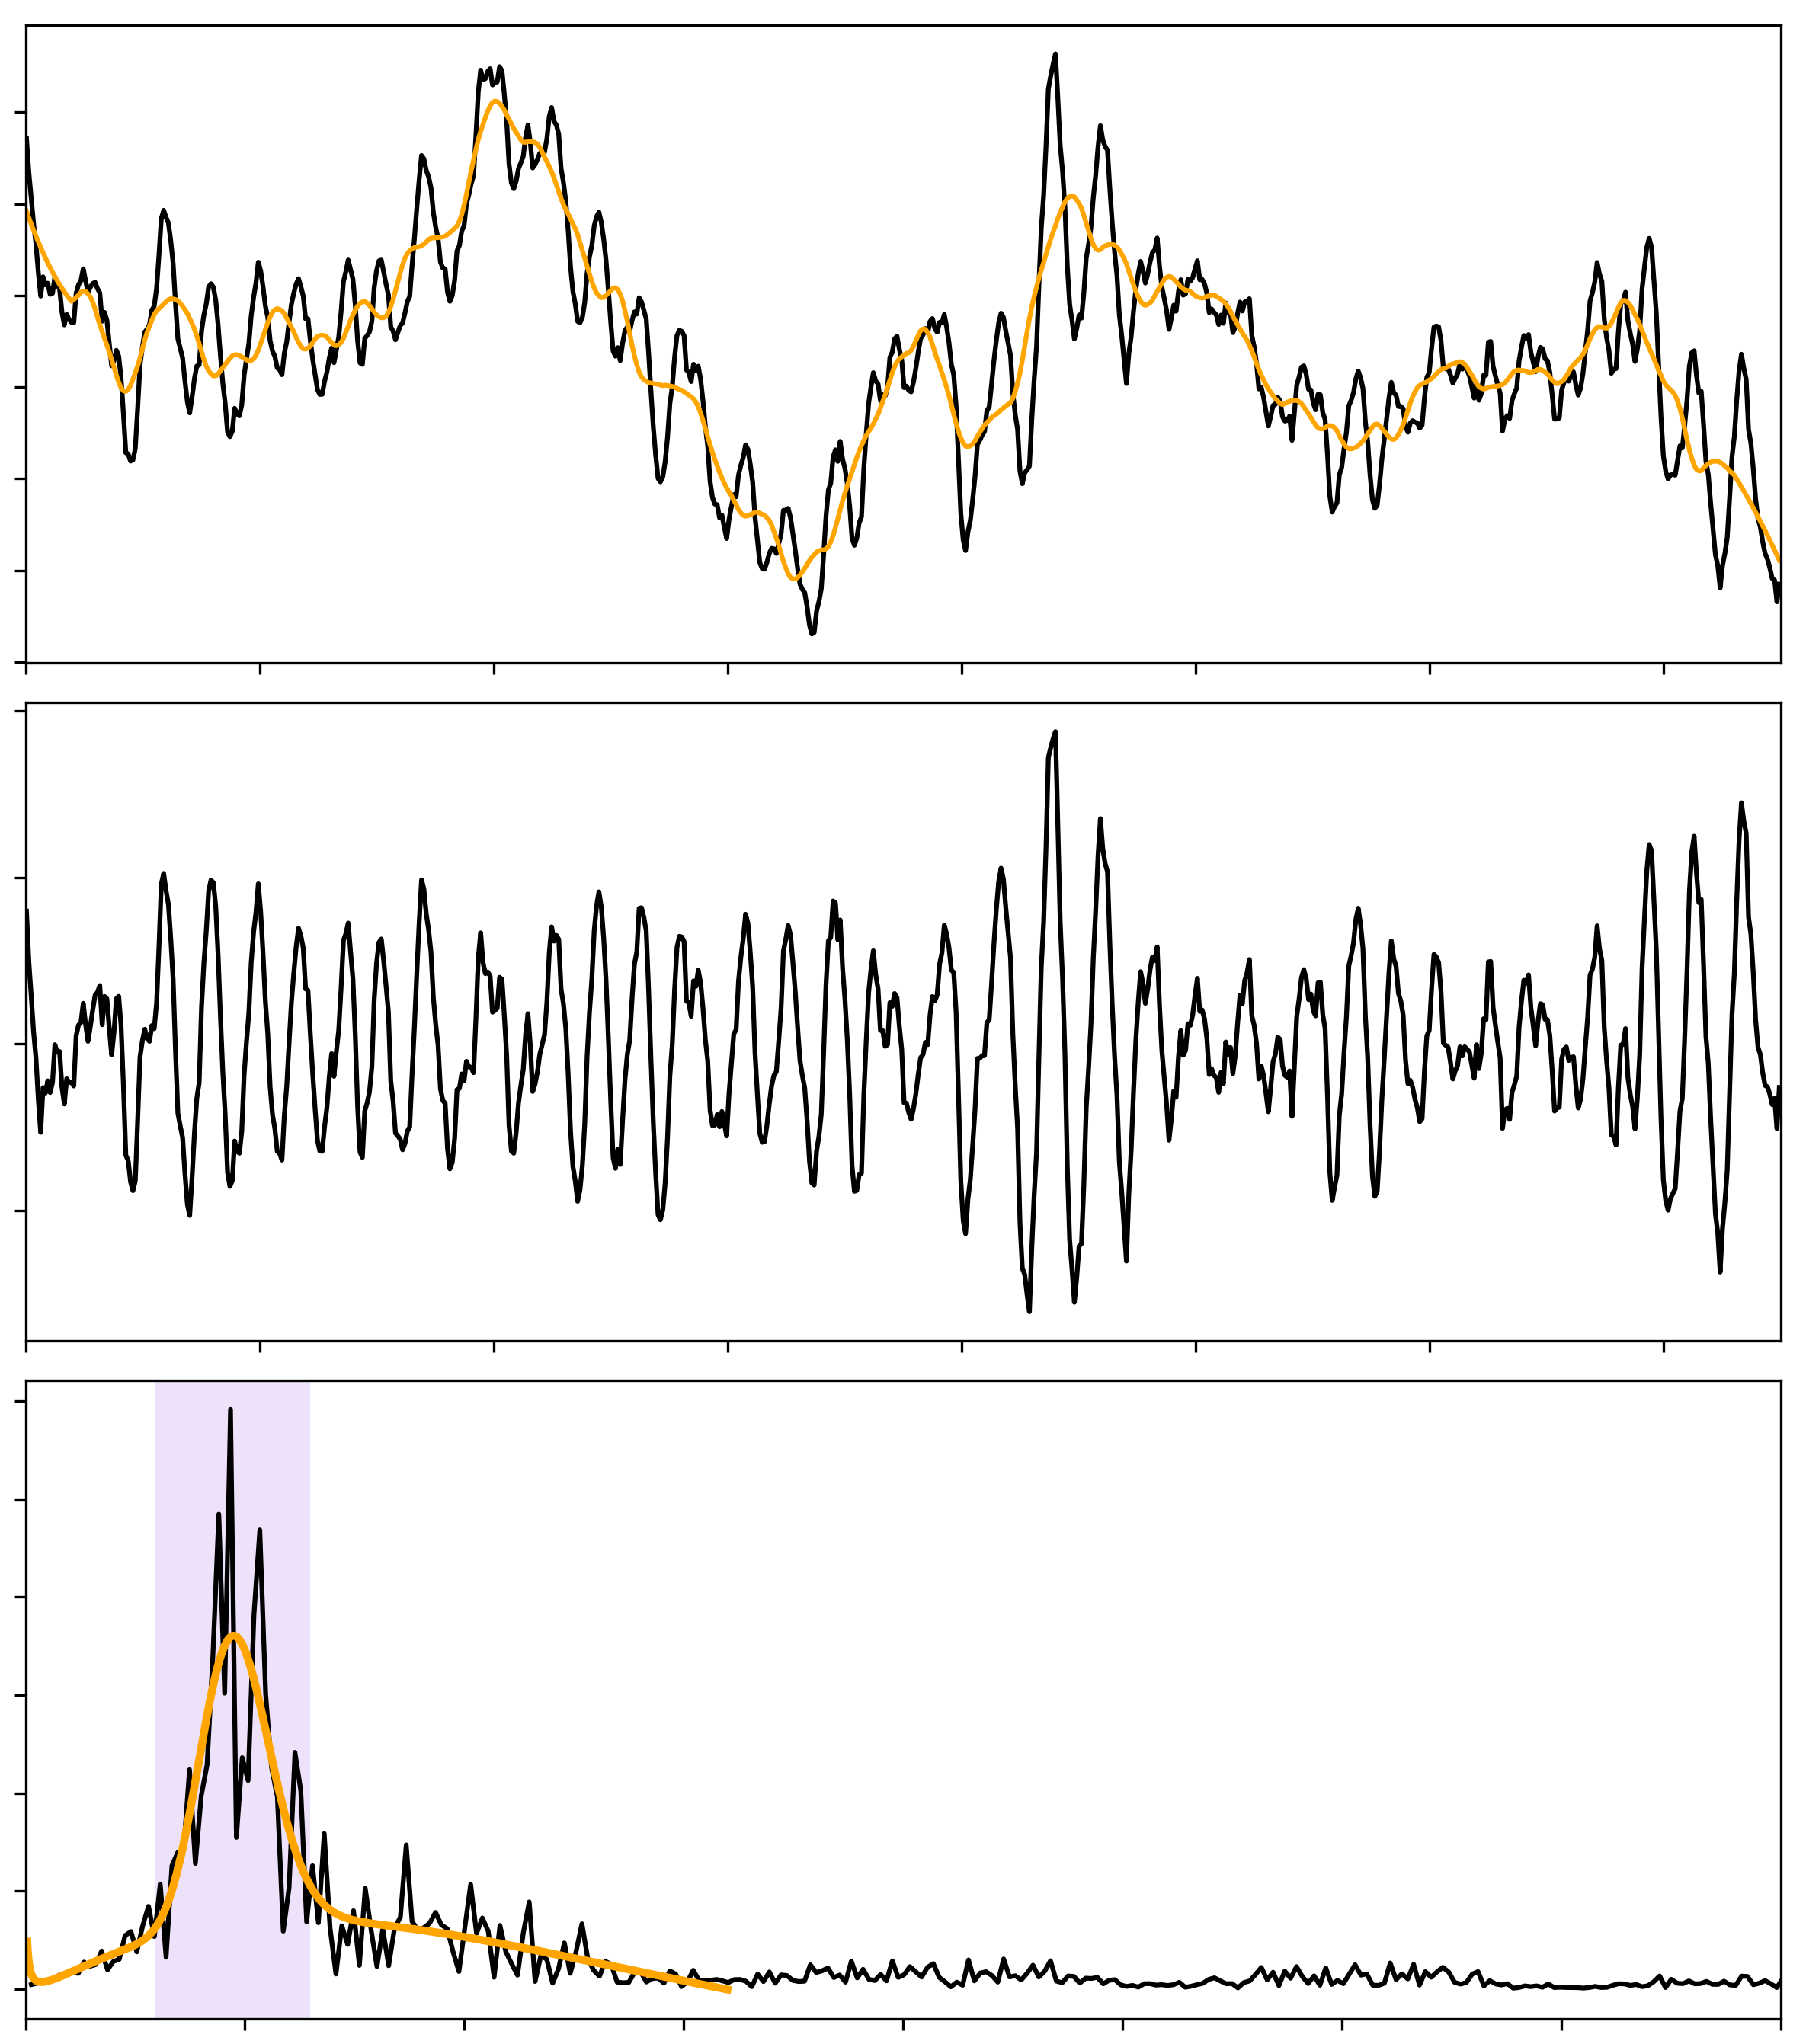

In [279]:
inputFile_1 = 'D:\\data\\2018-01-17\\2018-01-17_028.dat'
inputFiles = [inputFile_1]
labels =  ['2018-01-17_028'] 
windows = [39]
orders = [2]
column_B = 0
column_G = 3
R_lines = 18e3
V_AC = 20e-6

plot_name = 'fft_loop6'
B_min = 0.100
B_max = 0.250
T = '18 mK'
A_min = 0.61 #0.630 
A_max = 1.34 #1.313
A_center = 1.0 
order_filter = 7
fs = 25000     # sample rate, Hz
highpass_cutoff = 800  # desired cutoff frequency of the filter, Hz
lowpass_cutoff = 8000  # desired cutoff frequency of the filter, Hz

smooth_window = 5 #smooth window for FFT




a.magnetoconductance_range_special_bandpass(inputFiles, column_B, column_G, R_lines, V_AC, windows, orders, labels, plot_name,
                                            A_min, A_center, A_max, B_min, B_max, order_filter, fs, highpass_cutoff, lowpass_cutoff,
                                            smooth_window, f_max = 2000, angle_correction = True, smooth_data = True, plot = True, fitting = True,
                                            bandpass = False, smooth_fft = False,  locked_fit = True, only_fft = False)